In [26]:
import pandas as pd
import os
import gc
import json
from pathlib import Path
import seaborn as sns
from copy import copy
sns.mpl.rcParams['axes.formatter.useoffset'] = False
sns.set_style('whitegrid')
import numpy as np
from scipy.interpolate import interp1d, interp2d
from scipy.optimize import minimize, brentq
%matplotlib inline

root = '../calc/2017-01-23-all-vdw-sets-3'
import sys
sys.path.append(root)
import caf
from caflib.Cellar import Cellar
from caflib.Utils import slugify
import vdwsets.vdwsets as vdw

ev = 27.2107
kcal = 627.503

def get_some(d, *keys):
    for key in keys:
        if key in d:
            return d[key]
        
def normalize_names(col):
    if col.name == 'xc':
        return col.str.upper()
    return col

def savefig(**kwargs):
    sns.plt.savefig(os.path.expanduser('~/Downloads/fig.pdf'), transparent=True, **kwargs)

In [3]:
%%time
cellar = Cellar(f'{root}/.caf')
tree = cellar.get_tree(objects=True)
methods = [p.split('/')[-1] for p in tree.dglob('S22/*/*/<>')]

CPU times: user 4.44 s, sys: 1.51 s, total: 5.96 s
Wall time: 7.45 s


In [4]:
%%time
data_scf = []
data_mbd = []
data_dftd3_0 = []
data_dftd3_bj = []
for name, ds in vdw.get_all_datasets().items():
    for key, cluster in ds.clusters.items():
        keypath = slugify('_'.join(map(str, key)))
        system, dist = key if len(key) == 2 else (key[0], 1.)
        refs = cluster.energies
        ref = refs['ref'] if 'ref' in refs else refs['ref-grimme']
        for method in methods:
            enes = {}
            for fragment in cluster.fragments:
                path = f'{name}/{keypath}/{fragment}/{method}'
                hashid = tree[path]
                if 'outputs' not in tree.objects[hashid]:
                    continue
                results_file = 'mbd.json' if method == 'mbd' else 'results.json'
                filehash = tree.objects[hashid]['outputs'][results_file]
                with open(cellar.get_file(filehash)) as f:
                    results = json.load(f)
                enes[fragment] = list(sorted(results)) if method in ['mbd', 'dftd3'] else results['scf_energy']
            if len(enes) != len(cluster.fragments):
                continue
            if method == 'mbd':
                for i, (beta, a, _) in enumerate(list(enes.values())[0]):
                    data_mbd.append((
                        name, system, dist, a, beta, cluster.get_int_ene(
                            {f: enes[f][i][2] for f in cluster.fragments}
                        )*kcal,
                    ))
                data_mbd.append((name, system, dist, 6., 10., 0.))
            elif method == 'dftd3':
                for i, (damping, *params, _, _) in enumerate(list(enes.values())[0]):
                    (data_dftd3_0 if damping == 'zero' else data_dftd3_bj).append((
                        name, system, dist, *params,
                        cluster.get_int_ene(
                            {f: enes[f][i][-2] for f in cluster.fragments}
                        )*kcal,
                        cluster.get_int_ene(
                            {f: enes[f][i][-1] for f in cluster.fragments}
                        )*kcal
                    ))
                data_dftd3_bj.append((name, system, dist, 1., 50., 1., 0., 0.))
                data_dftd3_0.append((name, system, dist, 10., 10., 1., 0., 0.))
            else:
                data_scf.append((
                    name, system, dist, method,
                    cluster.get_int_ene(enes)/ev*kcal, ref,
                    len(ds.geoms[get_some(cluster.fragments, 'complex', 'dimer', 'crystal', 'ABC')])
                ))
data_scf = pd.DataFrame.from_records(
    data_scf,
    columns='name system dist xc ene ref natoms'.split()
).set_index('name system dist xc'.split(), verify_integrity=True).sort_index()
data_mbd = pd.DataFrame.from_records(
    data_mbd,
    columns='name system dist a beta ene'.split()
).set_index('name system dist a beta'.split(), verify_integrity=True).sort_index()
data_dftd3_0 = pd.DataFrame.from_records(
    data_dftd3_0,
    columns='name system dist sr6 sr8 s8 ene ene3'.split()
).set_index('name system dist sr6 sr8 s8'.split(), verify_integrity=True).sort_index()
data_dftd3_bj = pd.DataFrame.from_records(
    data_dftd3_bj,
    columns='name system dist a1 a2 s8 ene ene3'.split()
).set_index('name system dist a1 a2 s8'.split(), verify_integrity=True).sort_index()
gc.collect()

CPU times: user 3min 46s, sys: 24.9 s, total: 4min 11s
Wall time: 5min 8s


In [5]:
len(data_scf), len(data_mbd), len(data_dftd3_bj), len(data_dftd3_0)

(14651, 183222, 7153575, 815451)

In [6]:
mask = (data_scf.index.get_level_values('dist') == 2.) & (data_scf['ref'] >= 0)
data_scf.drop(data_scf.loc[mask].index, inplace=True)

In [7]:
def mod_ref1(df):
    if len(df) == 1:
        return df
    ibase = df['ref'].idxmin()
    base = df.loc[ibase, 'base']
    dist = ibase[2]
    mask = (df.index.get_level_values('dist') < dist) & (df['base'] < base)
    df.loc[mask, 'base'] = base
    return df

data_scf = data_scf \
    .assign(base=lambda x: abs(x['ref'])) \
    .groupby(level='name system xc'.split()) \
    .apply(mod_ref1)

In [8]:
def get_stat(df):
    return pd.Series({
        'STD': df['reldelta'].std(),
        'mean': df['reldelta'].mean(),
        'MARE': abs(df['reldelta']).mean(),
        'MAE': abs(df['delta']).mean()
    })
    
def plot_stat(**kwargs):
    df = kwargs.pop('data').groupby('beta').apply(get_stat).reset_index()
    mean = interp1d(df['beta'], df['mean'], kind='cubic')
    std = interp1d(df['beta'], df['STD'], kind='cubic')
    mare = interp1d(df['beta'], df['MARE'], kind='cubic')
    beta = np.linspace(df['beta'].min(), df['beta'].max())
    sns.plt.plot(beta, mean(beta), '--', **kwargs)
    sns.plt.plot(beta, std(beta), '-', **kwargs)
    sns.plt.plot(beta, mare(beta), ':', **kwargs)
    sns.plt.axhline(color='black')

def zero_dist(df):
    df = df.copy()
    df['dist'] = 1.
    df['name'] = df['name'] + '_T'
    return df

## MBD

In [9]:
data = pd.merge(
    data_scf.reset_index(),
    data_mbd.reset_index(),
    on='name system dist'.split(),
    how='inner',
    suffixes=('_scf', '_mbd')
).set_index('name xc system dist a beta'.split()).sort_index()

In [10]:
data = data \
    .assign(ene=lambda x: x['ene_scf']+x['ene_mbd']) \
    .assign(delta=lambda x: x['ene']-x['ref']) \
    .assign(reldelta=lambda x: x['delta']/x['base'])

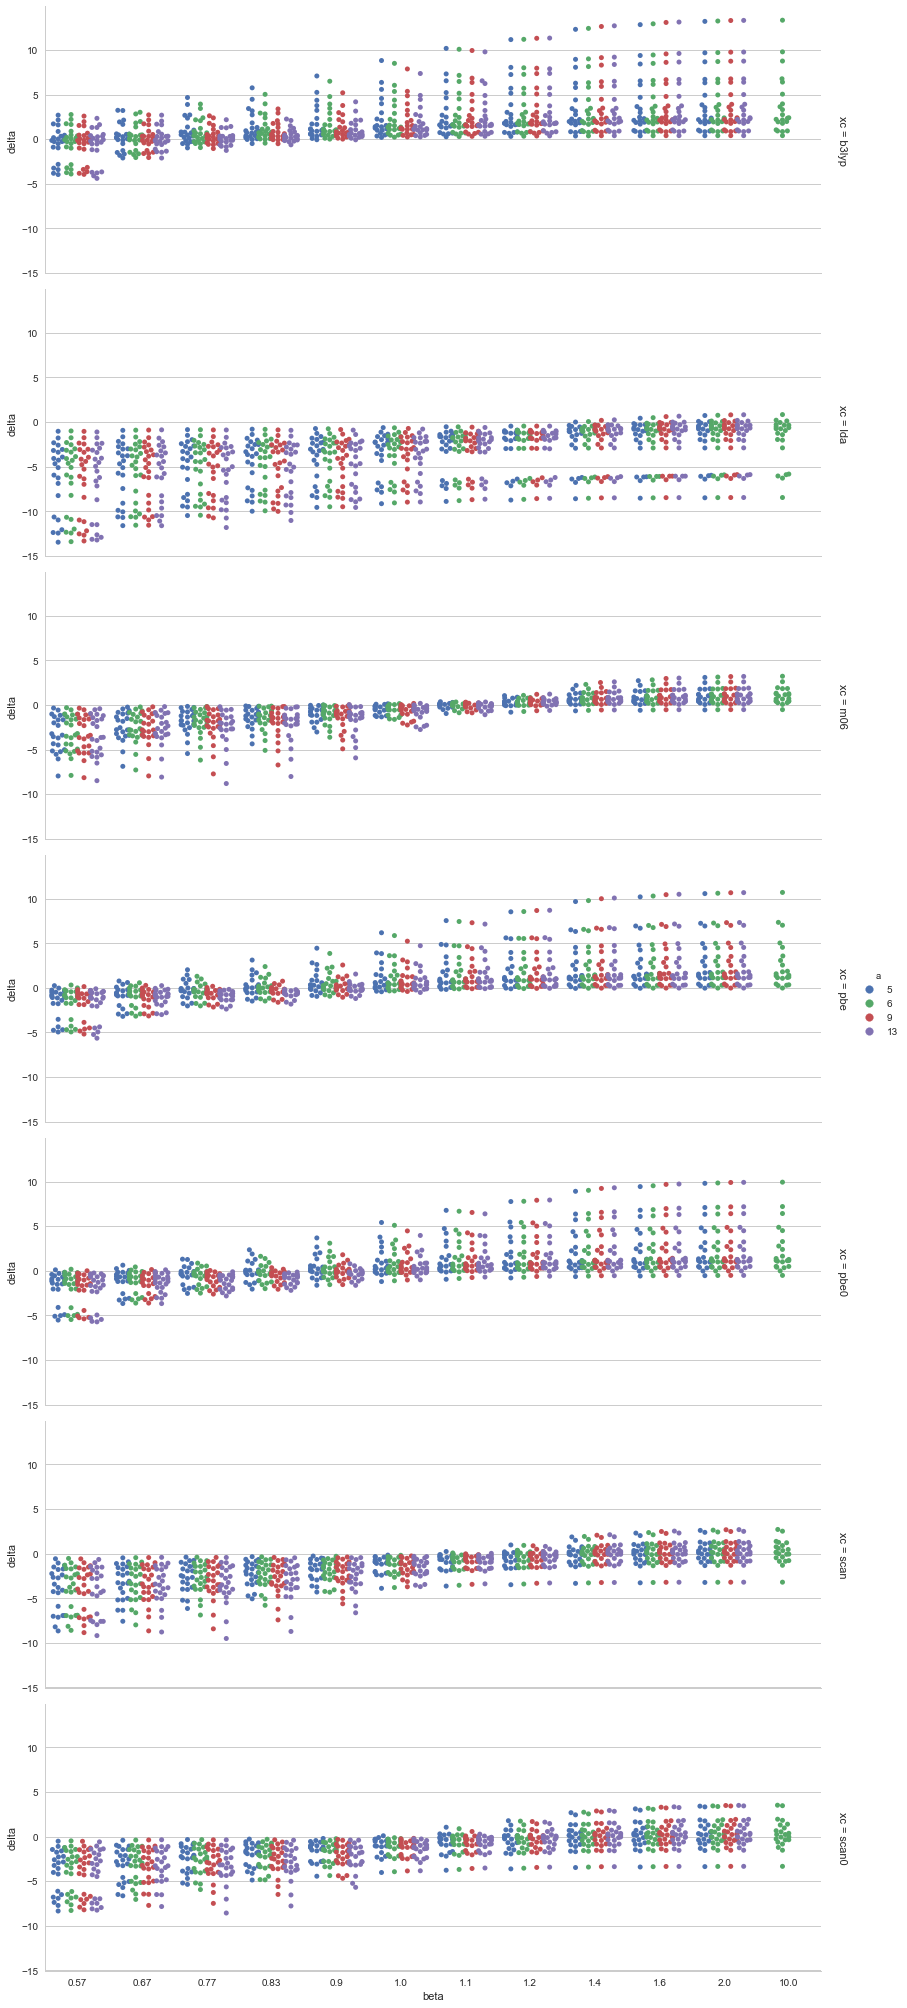

In [55]:
sns.factorplot(
    data=data.loc[(
        'S22',
        ['pbe', 'scan', 'pbe0', 'scan0', 'lda', 'm06', 'b3lyp'],
        slice(None),
        slice(None),
        [5, 6, 9, 13],
        [.57, .67, .77, .83, .9, 1., 1.1, 1.2, 1.4, 1.6, 2., 10.]
    ), :].reset_index(),
    kind='swarm',
    x='beta',
    y='delta',
    row='xc',
    hue='a',
    aspect=3,
    split=True,
    margin_titles=True
)

(-1, 1)

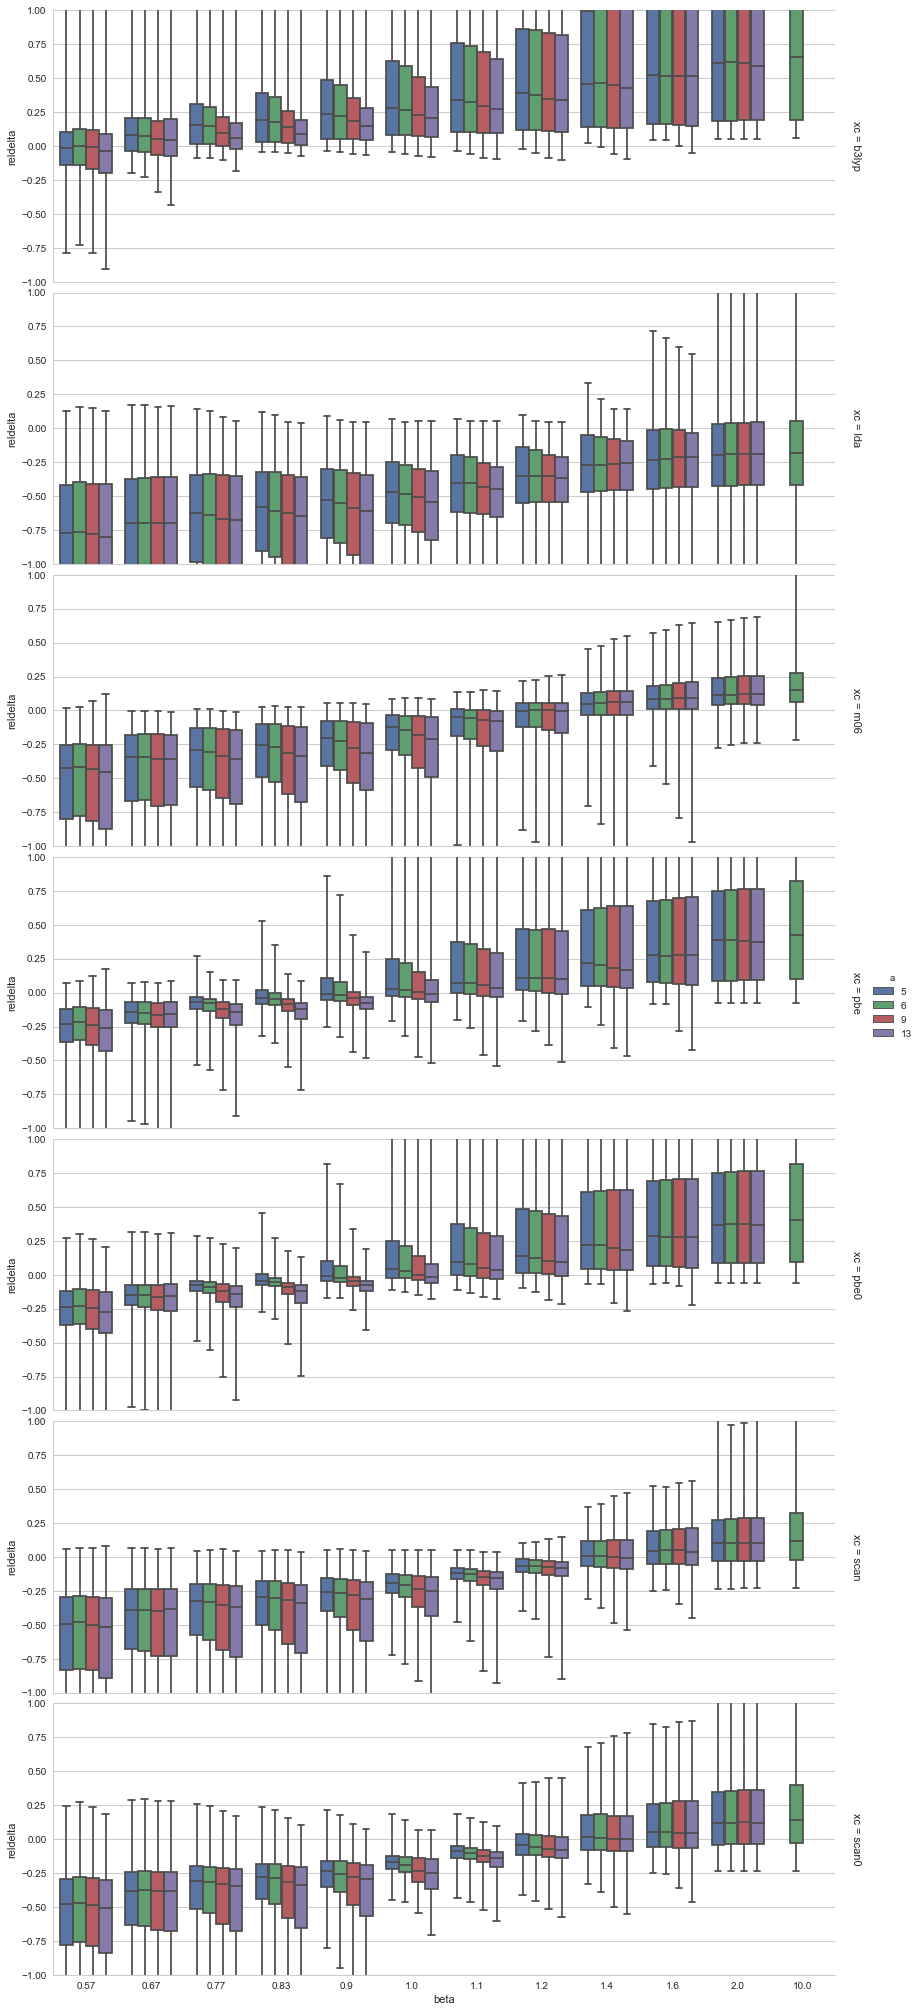

In [56]:
sns.factorplot(
    data=data.loc[(
        'S66x8',
        ['pbe', 'scan', 'pbe0', 'scan0', 'lda', 'm06', 'b3lyp'],
        slice(None),
        slice(None),
        [5, 6, 9, 13],
        [.57, .67, .77, .83, .9, 1., 1.1, 1.2, 1.4, 1.6, 2., 10.],
    ), :].reset_index(),
    kind='box',
    x='beta',
    y='reldelta',
    whis=10,
    row='xc',
    hue='a',
    aspect=3,
    margin_titles=True
)
sns.plt.ylim(-1, 1)

(-1, 1)

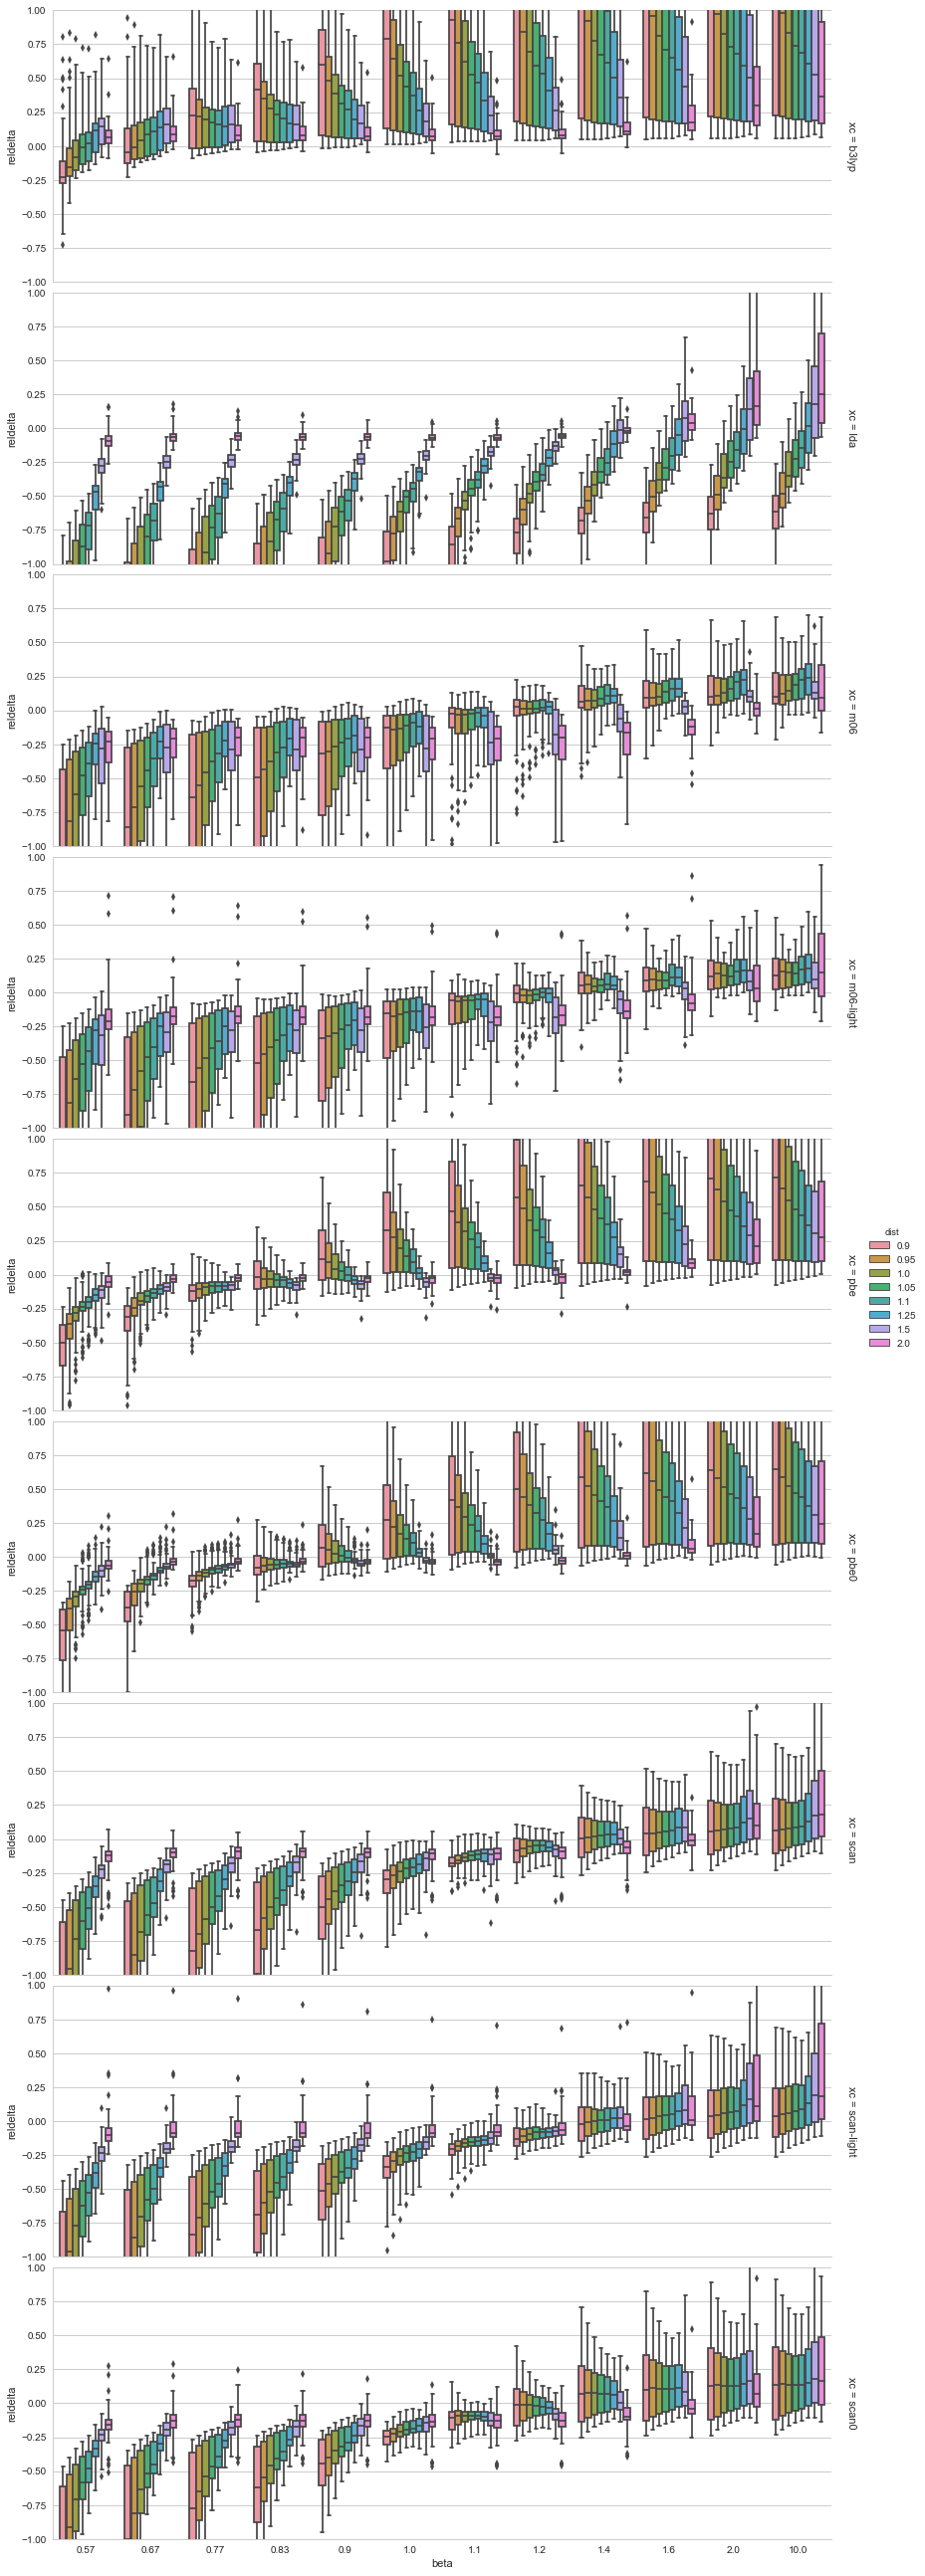

In [57]:
sns.factorplot(
    data=data.loc[(
        'S66x8',
        ['pbe', 'pbe', 'scan', 'scan-light', 'pbe0', 'scan0', 'lda', 'm06', 'm06-light', 'b3lyp'],
        slice(None),
        slice(None),
        6,
        [.57, .67, .77, .83, .9, 1., 1.1, 1.2, 1.4, 1.6, 2., 10.],
    ), :].reset_index(),
    kind='box',
    x='beta',
    y='reldelta',
    row='xc',
    hue='dist',
    whis=2.5,
    aspect=3,
    margin_titles=True
)
sns.plt.ylim(-1, 1)

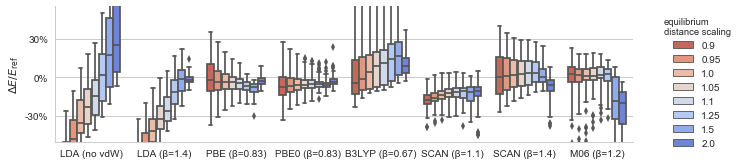

In [15]:
def get_name(row):
    name = row['xc'].upper()
    name += f' (β={row["beta"]})' if row['beta'] != 10. else ' (no vdW)'
    return name

with sns.color_palette(list(reversed(sns.color_palette('coolwarm', 8)))):
    g = sns.factorplot(
        data=pd.concat([
            data.loc[('S66x8', 'lda', slice(None), slice(None), 6, 10.), :].reset_index(),
            data.loc[('S66x8', 'lda', slice(None), slice(None), 6, 1.4), :].reset_index(),
            data.loc[('S66x8', 'pbe', slice(None), slice(None), 6, .83), :].reset_index(),
            data.loc[('S66x8', 'pbe0', slice(None), slice(None), 6, .83), :].reset_index(),
            data.loc[('S66x8', 'b3lyp', slice(None), slice(None), 6, .67), :].reset_index(),
            data.loc[('S66x8', 'scan', slice(None), slice(None), 6, 1.1), :].reset_index(),
            data.loc[('S66x8', 'scan', slice(None), slice(None), 6, 1.4), :].reset_index(),
            data.loc[('S66x8', 'm06', slice(None), slice(None), 6, 1.2), :].reset_index(),
        ]).assign(xc_beta=lambda x: x.apply(get_name, axis=1))
        .rename(columns={'dist': 'equilibrium\ndistance scaling'}),
        kind='box',
        x='xc_beta',
        y='reldelta',
        hue='equilibrium\ndistance scaling',
        whis=2.5,
        aspect=3.5,
        size=2.6,
        margin_titles=True
    )
sns.plt.ylim(-.5, .55)
g.set_xlabels('')
g.set_ylabels(r'$\Delta E/E_\mathrm{ref}$')
g.set(yticks=[-.3, 0, .3])
g.set_yticklabels(['-30%', '0%', '30%'])
savefig()

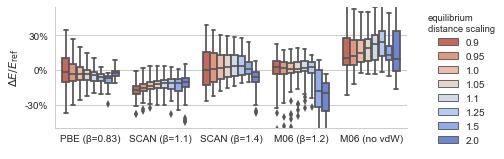

In [61]:
def get_name(row):
    name = row['xc'].upper()
    name += f' (β={row["beta"]})' if row['beta'] != 10. else ' (no vdW)'
    return name

with sns.color_palette(list(reversed(sns.color_palette('coolwarm', 8)))):
    g = sns.factorplot(
        data=pd.concat([
            data.loc[('S66x8', 'pbe', slice(None), slice(None), 6, .83), :].reset_index(),
            data.loc[('S66x8', 'scan', slice(None), slice(None), 6, 1.1), :].reset_index(),
            data.loc[('S66x8', 'scan', slice(None), slice(None), 6, 1.4), :].reset_index(),
            data.loc[('S66x8', 'm06', slice(None), slice(None), 6, 1.2), :].reset_index(),
            data.loc[('S66x8', 'm06', slice(None), slice(None), 6, 10.), :].reset_index(),
        ]).assign(xc_beta=lambda x: x.apply(get_name, axis=1))
        .rename(columns={'dist': 'equilibrium\ndistance scaling'}),
        kind='box',
        x='xc_beta',
        y='reldelta',
        hue='equilibrium\ndistance scaling',
        whis=2.5,
        aspect=2.5,
        size=2.4,
        margin_titles=True
    )
sns.plt.ylim(-.5, .55)
g.set_xlabels('')
g.set_ylabels(r'$\Delta E/E_\mathrm{ref}$')
g.set(yticks=[-.3, 0, .3])
g.set_yticklabels(['-30%', '0%', '30%'])
savefig()

In [33]:
data.loc[('S66x8', 'b3lyp', slice(None), slice(None), 6, .67), :].sort_values('reldelta').iloc[-5:]

ene_scf   ref  natoms  base  \
name  xc    system              dist a   beta                                 
S66x8 b3lyp Benzene ...  Ethene 1.00 6.0 0.67  2.204145 -1.41      18  1.41   
                                1.25 6.0 0.67  0.655588 -0.69      18  0.69   
                                0.95 6.0 0.67  3.279963 -1.13      18  1.41   
                                0.90 6.0 0.67  5.099368 -0.26      18  1.41   
                                1.50 6.0 0.67  0.335828 -0.17      18  0.17   

                                                ene_mbd       ene     delta  \
name  xc    system              dist a   beta                                 
S66x8 b3lyp Benzene ...  Ethene 1.00 6.0 0.67 -2.463853 -0.259708  1.150292   
                                1.25 6.0 0.67 -0.781361 -0.125773  0.564227   
                                0.95 6.0 0.67 -3.149605  0.130358  1.260358   
                                0.90 6.0 0.67 -4.030034  1.069334  1.329334   
                                1.50 6.0 0.67 -0.291828  0.044001  0.214001   

                                               reldelta  
name  xc    system              dist a   beta            
S66x8 b3lyp Benzene ...  Ethene 1.00 6.0 0.67  0.815810  
                                1.25 6.0 0.67  0.817720  
                                0.95 6.0 0.67  0.893871  
                                0.90 6.0 0.67  0.942790  
                                1.50 6.0 0.67  1.258826

In [63]:
data.loc[('S66x8', ['pbe', 'pbe0'], slice(None), 1., 6, .67), 'reldelta'].unstack(1) \
.assign(delta=lambda x: np.abs(x.pbe)-np.abs(x.pbe0)).sort_values('delta').iloc[-5:]

xc                                                     pbe      pbe0     delta
name  system                         dist a beta                              
S66x8 Cyclopentane ...  Cyclopentane 1.0  6 0.67 -0.454992 -0.420399  0.034594
      Ethene ...  Pentane            1.0  6 0.67 -0.432813 -0.397530  0.035283
      Ethyne ...  Pentane            1.0  6 0.67 -0.376497 -0.338907  0.037590
      Benzene ...  Ethene            1.0  6 0.67 -0.105193 -0.045194  0.059999
      Neopentane ...  Neopentane     1.0  6 0.67 -0.485666 -0.414892  0.070774

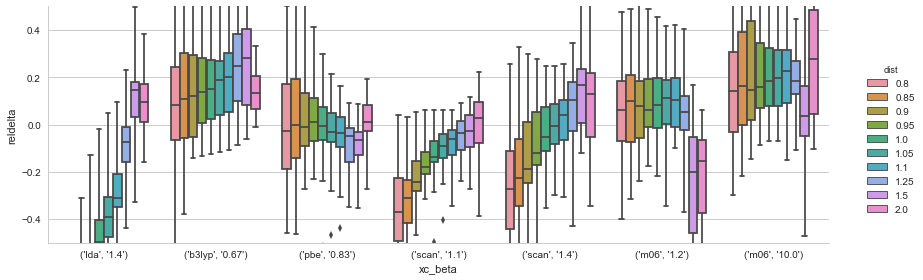

In [64]:
sns.factorplot(
    data=pd.concat([
        data.loc[('X40x10', 'lda', slice(None), slice(None), 6, 1.4), :].reset_index(),
        data.loc[('X40x10', 'b3lyp', slice(None), slice(None), 6, .67), :].reset_index(),
        data.loc[('X40x10', 'pbe', slice(None), slice(None), 6, .83), :].reset_index(),
        data.loc[('X40x10', 'scan', slice(None), slice(None), 6, 1.1), :].reset_index(),
        data.loc[('X40x10', 'scan', slice(None), slice(None), 6, 1.4), :].reset_index(),
        data.loc[('X40x10', 'm06', slice(None), slice(None), 6, 1.2), :].reset_index(),
        data.loc[('X40x10', 'm06', slice(None), slice(None), 6, 10.), :].reset_index(),
    ]).assign(xc_beta=lambda x: list(zip(x['xc'], x['beta'].astype(str)))),
    kind='box',
    x='xc_beta',
    y='reldelta',
    hue='dist',
    whis=2.5,
    aspect=3,
    margin_titles=True
)
sns.plt.ylim(-.5, .5)
savefig()

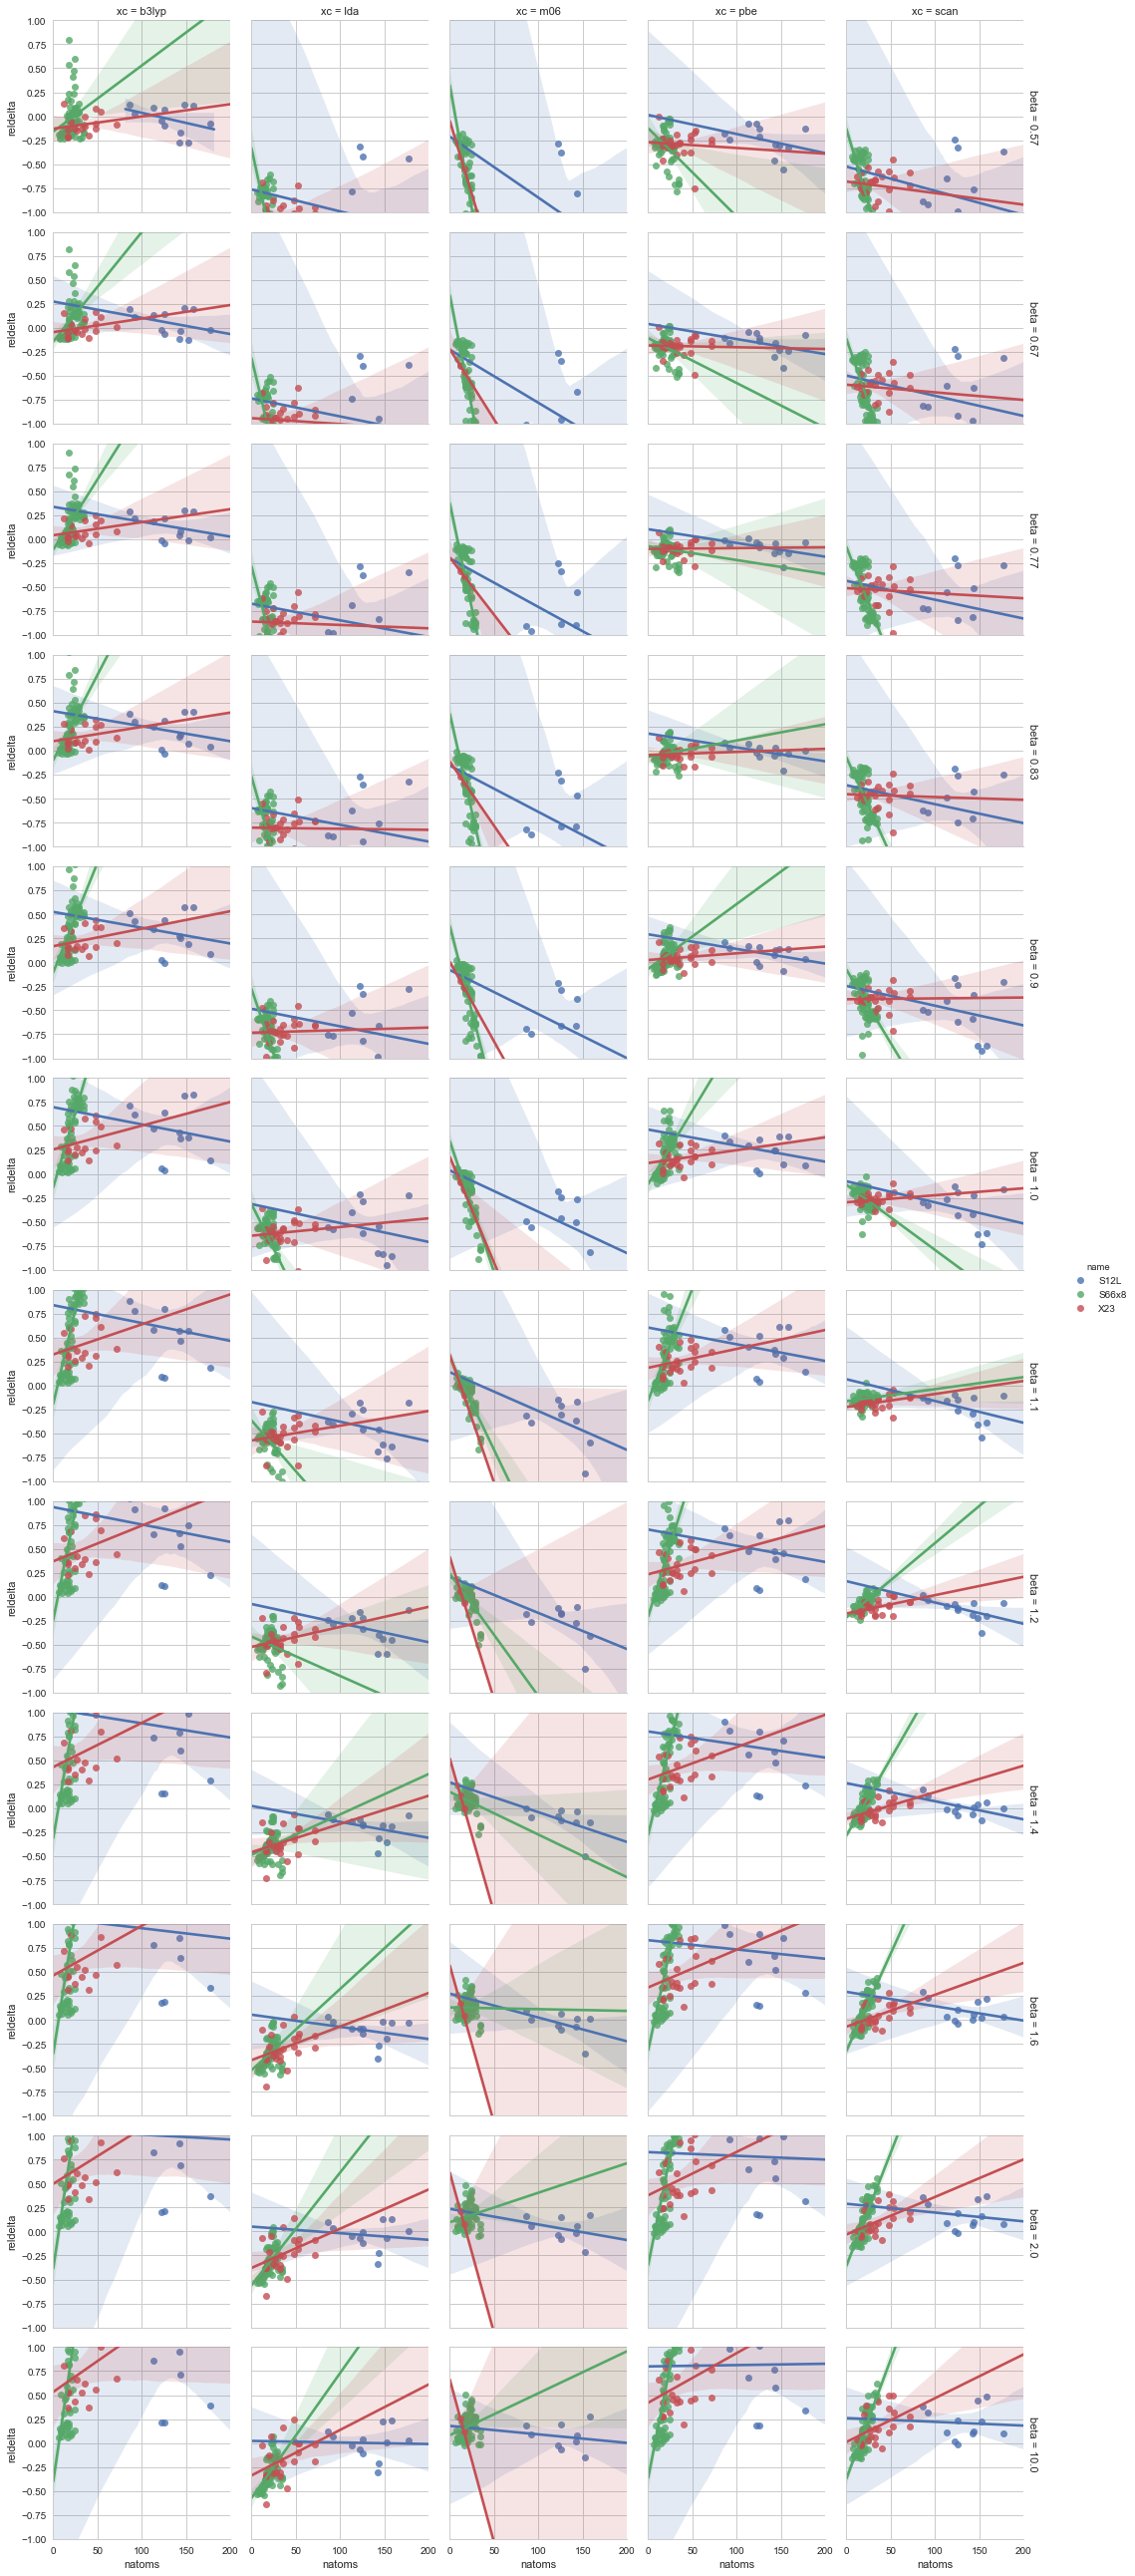

In [65]:
def regplot(*args, **kwargs):
    sns.regplot(*args, **kwargs)
    sns.plt.xlim(0, 200)
    sns.plt.ylim(-1, 1)
    
sns.FacetGrid(
    data=data.loc[(
        ['S66x8', 'S12L', 'X23'],
        ['pbe', 'scan', 'lda', 'm06', 'b3lyp'],
        slice(None),
        1.,
        6,
        [.57, .67, .77, .83, .9, 1., 1.1, 1.2, 1.4, 1.6, 2., 10.],
    ), :].reset_index(),
    row='beta',
    col='xc',
    hue='name',
    margin_titles=True
).map(regplot, 'natoms', 'reldelta').add_legend()

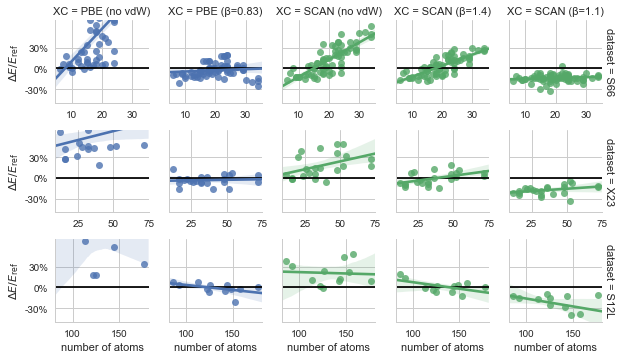

In [66]:
def regplot(*args, **kwargs):
    sns.plt.axhline(color='black')
    # sns.kdeplot(*args, **kwargs, n_levels=5)
    sns.regplot(*args, **kwargs)
    
def get_name(row):
    name = row['xc'].upper()
    name += f' (β={row["beta"]})' if row['beta'] != 10. else ' (no vdW)'
    return name

g = sns.FacetGrid(
    data=pd.concat([
        data.loc[(['S66x8', 'S12L', 'X23'], 'pbe', slice(None), 1., 6, 10.), :].reset_index(),
        data.loc[(['S66x8', 'S12L', 'X23'], 'pbe', slice(None), 1., 6, .83), :].reset_index(),
        data.loc[(['S66x8', 'S12L', 'X23'], 'scan', slice(None), 1., 6, 10.), :].reset_index(),
        data.loc[(['S66x8', 'S12L', 'X23'], 'scan', slice(None), 1., 6, 1.4), :].reset_index(),
        data.loc[(['S66x8', 'S12L', 'X23'], 'scan', slice(None), 1., 6, 1.1), :].reset_index(),
    ]).assign(XC=lambda x: x.apply(get_name, axis=1))
    .rename(columns={'natoms': 'number of atoms', 'name': 'dataset'})
    .replace('S66x8', 'S66'),
    col='XC',
    row_order='S66 X23 S12L'.split(),
    row='dataset',
    hue='xc',
    size=1.7,
    margin_titles=True,
    sharex=False,
).map(regplot, 'number of atoms', 'reldelta')
g.fig.subplots_adjust(left=0.08)
sns.plt.ylim(-.5, .7)
# g.set_xlabels(r'$\beta$')
g.set_ylabels(r'$\Delta E/E_\mathrm{ref}$')
# xticks = [.6, .8, 1, 1.2, 1.4]
yticks = [-.3, 0, .3]
g.set(yticks=yticks)
# g.set_xticklabels(xticks)
g.set_yticklabels(['-30%', '0%', '30%'])
savefig()

(-2, 2)

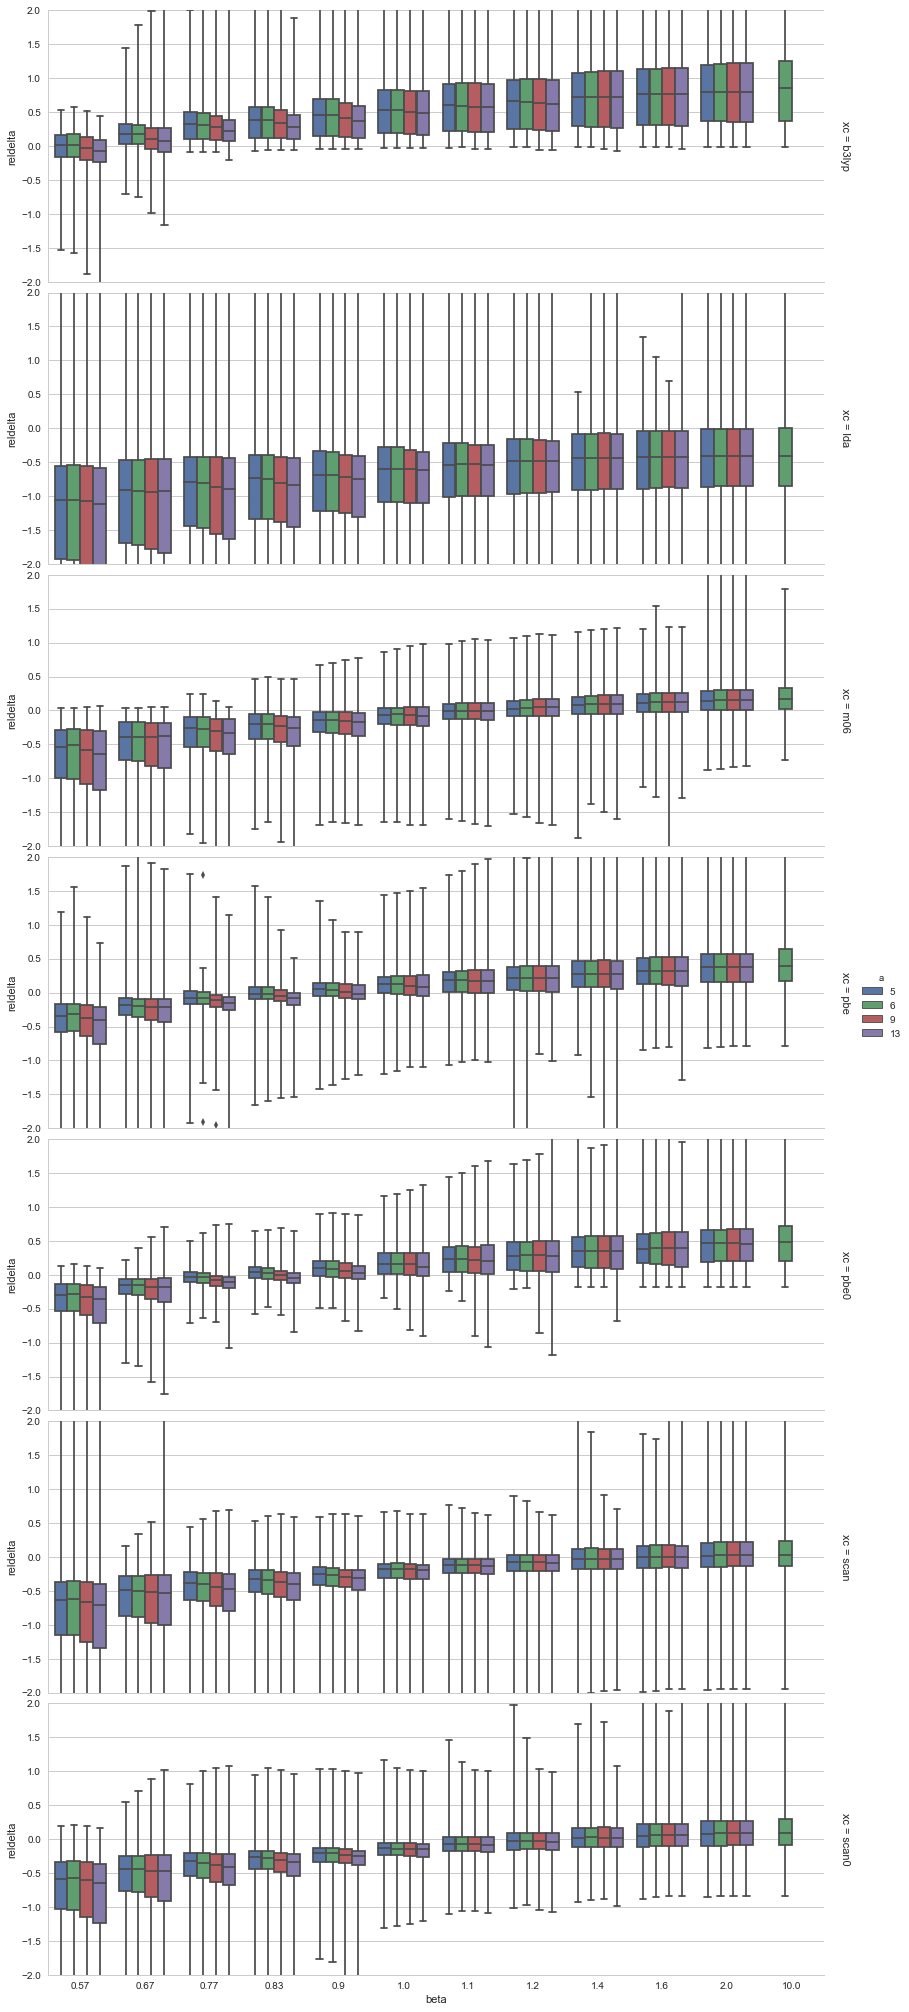

In [67]:
sns.factorplot(
    data=data.loc[(
        'X40x10',
        ['pbe', 'scan', 'pbe0', 'scan0', 'lda', 'm06', 'b3lyp'],
        slice(None),
        slice(None),
        [5, 6, 9, 13],
        [.57, .67, .77, .83, .9, 1., 1.1, 1.2, 1.4, 1.6, 2., 10.],
    ), :].reset_index(),
    kind='box',
    x='beta',
    y='reldelta',
    whis=10,
    row='xc',
    hue='a',
    aspect=3,
    margin_titles=True
)
sns.plt.ylim(-2, 2)

(-1, 1)

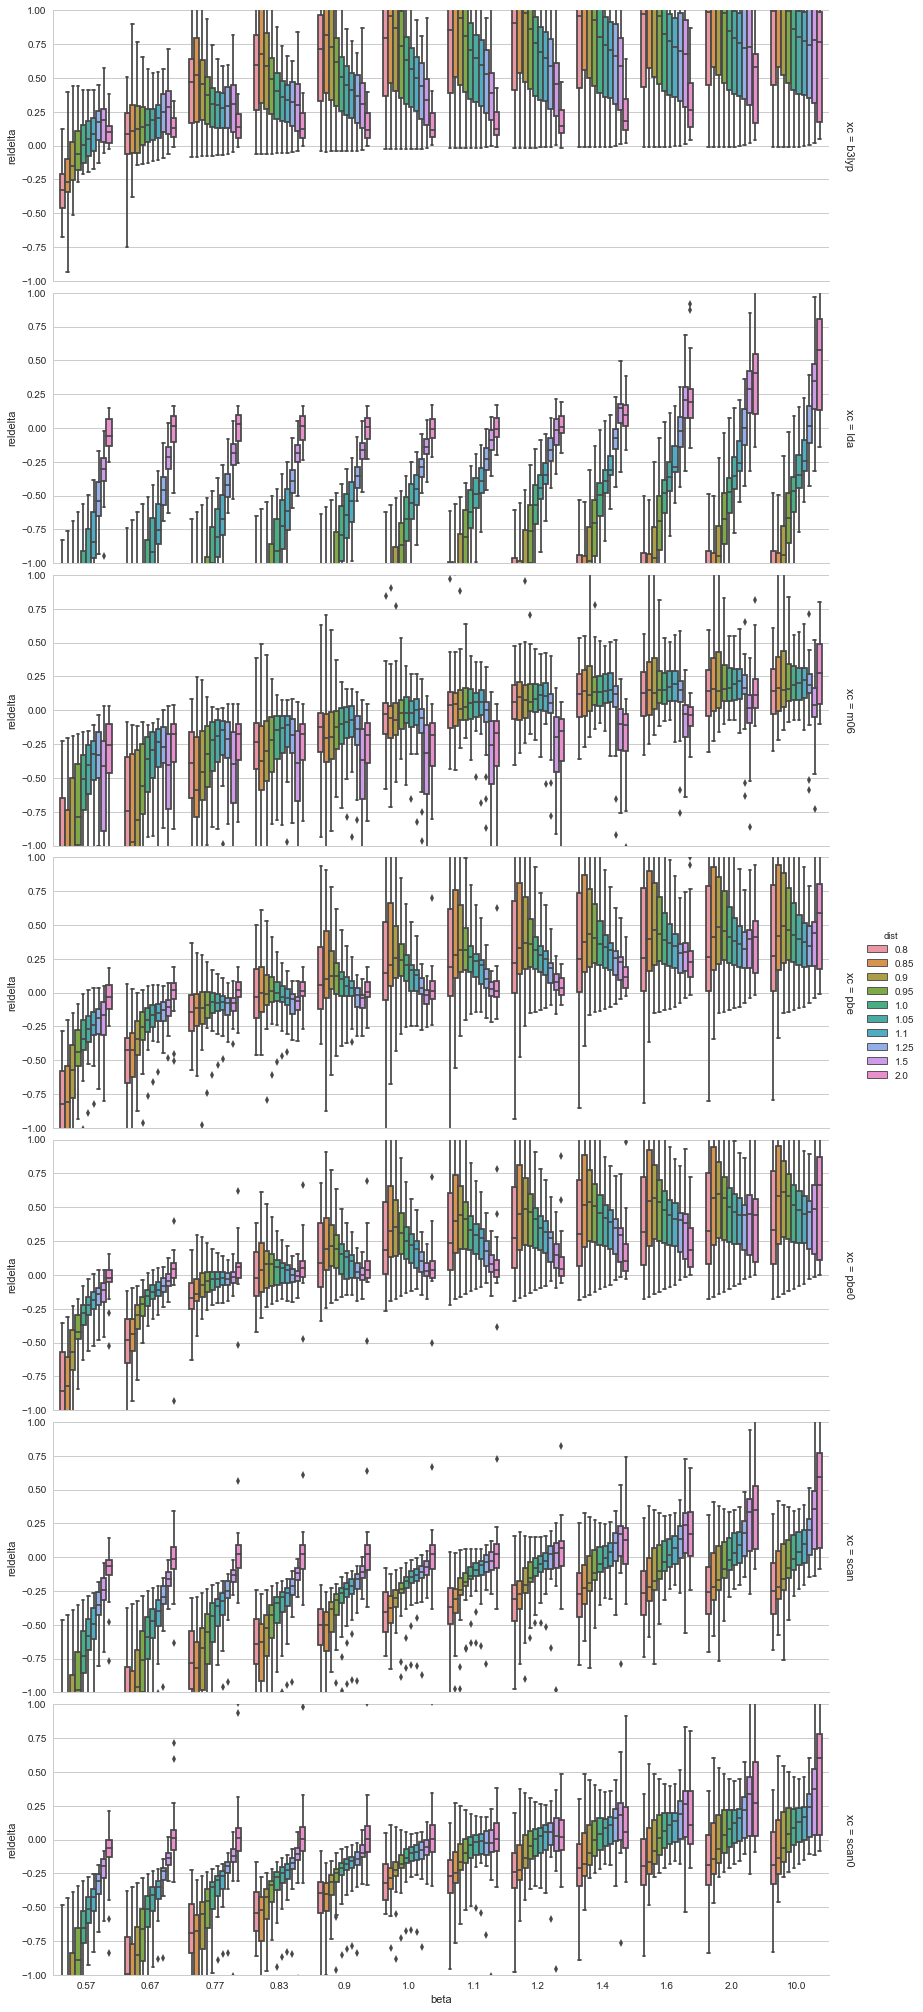

In [68]:
sns.factorplot(
    data=data.loc[(
        'X40x10',
        ['pbe', 'scan', 'pbe0', 'scan0', 'lda', 'm06', 'b3lyp'],
        slice(None),
        slice(None),
        6,
        [.57, .67, .77, .83, .9, 1., 1.1, 1.2, 1.4, 1.6, 2., 10.],
    ), :].reset_index(),
    kind='box',
    x='beta',
    y='reldelta',
    row='xc',
    hue='dist',
    whis=2.5,
    aspect=3,
    margin_titles=True
)
sns.plt.ylim(-1, 1)

(-0.6, 0.6)

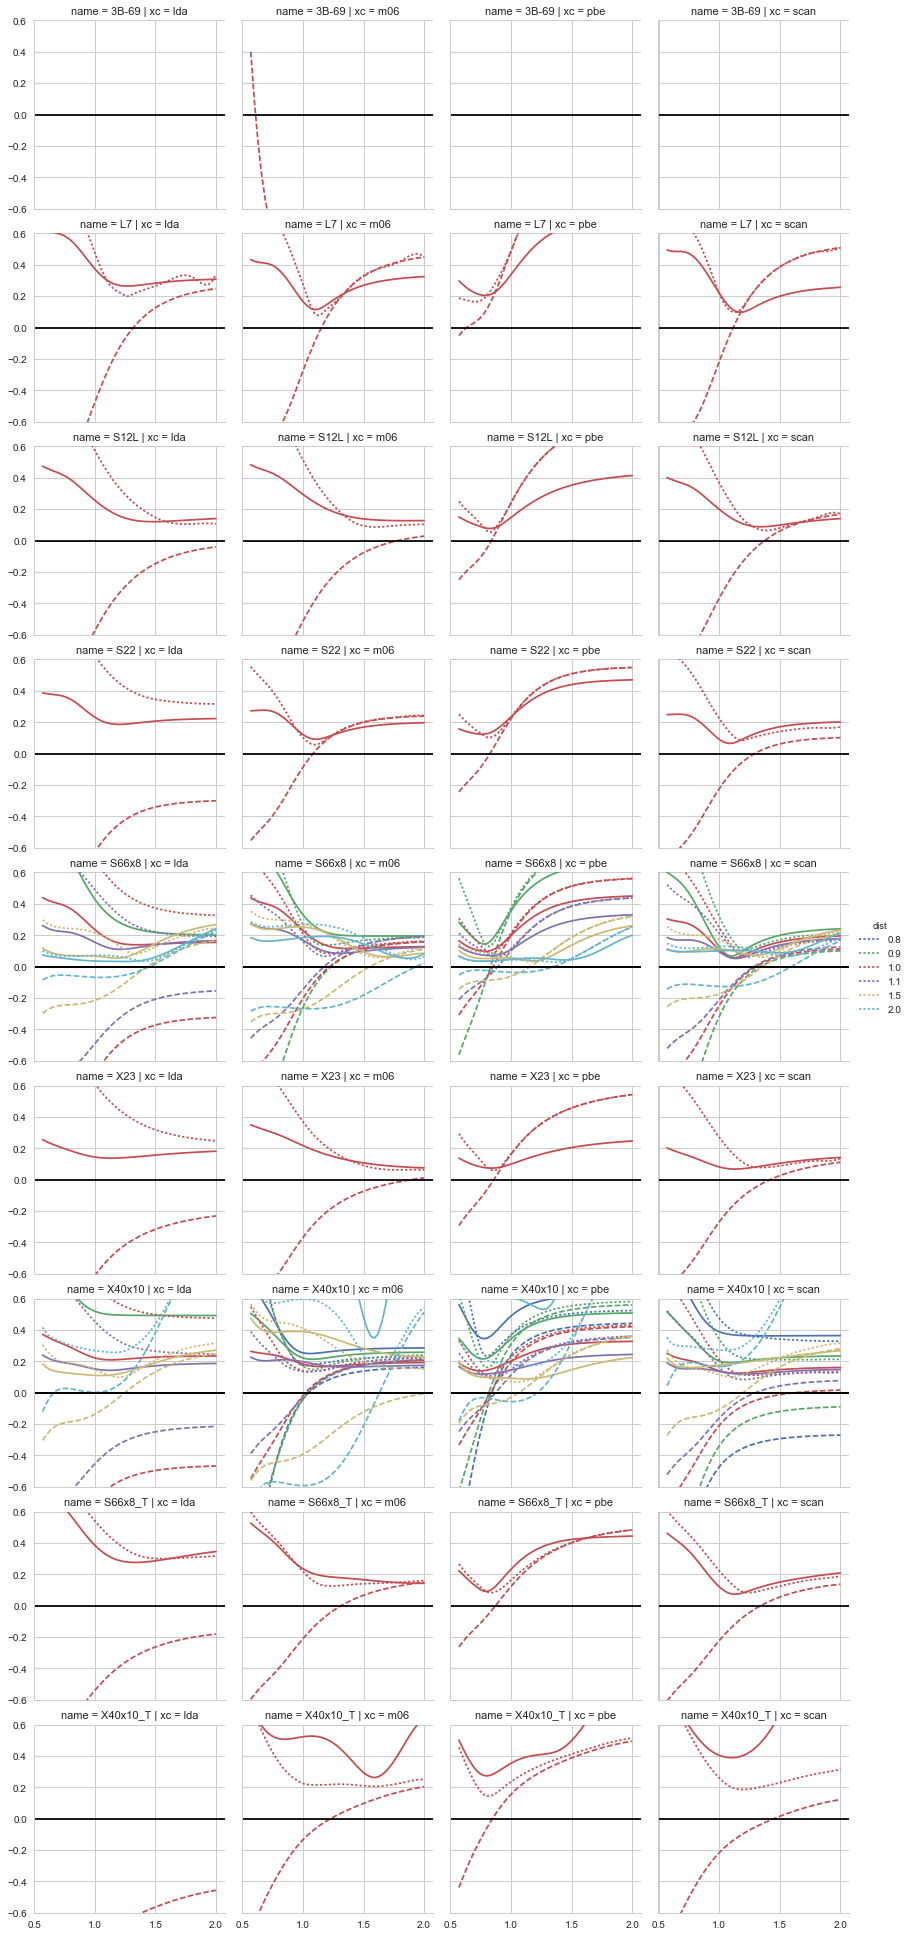

In [69]:
sns.FacetGrid(
    data=pd.concat([
        data.loc[(
            slice(None, 'X40x10'),
            ['pbe', 'scan', 'm06', 'm06-light', 'lda'],
            slice(None),
            [.8, .9, 1., 1.1, 1.5, 2.],
            6,
            slice(None, 2.)
        ), :].reset_index(),
        data.loc[(
            ['X40x10', 'S66x8'],
            ['pbe', 'scan', 'm06', 'm06-light', 'lda'],
            slice(None),
            slice(None),
            6,
            slice(None, 2.)
        ), :].reset_index().pipe(zero_dist)
    ])
    .loc[
        lambda x: (x['name'] == 'X23') & (x['xc'] == 'm06-light') |
            (x['name'] != 'X23') & (x['xc'] == 'm06') | ~x['xc'].str.contains('m06')
    ].replace('m06-light', 'm06'),
    row='name',
    col='xc',
    hue='dist'
).map_dataframe(plot_stat).add_legend()
sns.plt.ylim(-.6, .6)

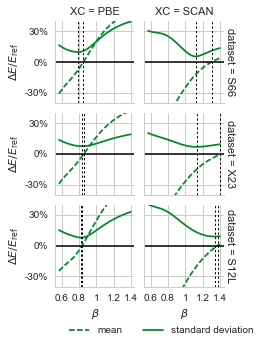

In [70]:
def plot_stat(**kwargs):
    global line1, line2
    df = kwargs.pop('data').groupby('beta').apply(get_stat).reset_index()
    mean = interp1d(df['beta'], df['mean'], kind='cubic')
    std = interp1d(df['beta'], df['STD'], kind='cubic')
    beta = np.linspace(df['beta'].min(), df['beta'].max())
    line1, = sns.plt.plot(beta, mean(beta), '--', color='#00882B')
    line2, = sns.plt.plot(beta, std(beta), '-', color='#00882B')
    bounds = [(df['beta'].min()+1e-6, df['beta'].max()-1e-6)]
    opt_std = minimize(std, 1.6, bounds=bounds).x[0]
    opt_mean = brentq(mean, *bounds[0]) \
            if np.sign(mean(bounds[0][0])) != np.sign(mean(bounds[0][1])) \
            else bounds[0][1]
    sns.plt.axhline(color='black', lw=1.5)
    sns.plt.axvline(opt_std, color='black', ls='dotted', lw=1)
    sns.plt.axvline(opt_mean, color='black', ls='dotted', lw=1)

g = sns.FacetGrid(
    data.loc[(
        'S12L S22 S66x8 X23 X40x10'.split(),
        'pbe scan'.split(),
        slice(None),
        1.,
        6,
        slice(None, 1.5)
    ), :].reset_index()
    .apply(normalize_names)
    .replace('S66x8', 'S66')
    .rename(columns={'xc': 'XC', 'name': 'dataset'}), 
    col='XC',
    row_order='S66 X23 S12L'.split(),
    row='dataset',
    size=1.6,
    margin_titles=True
).map_dataframe(plot_stat)
g.fig.legend(
    (line1, line2), ('mean', 'standard deviation'),
    loc='lower center', bbox_to_anchor=(.7, 0), ncol=2
)
g.fig.subplots_adjust(bottom=0.16, left=0.2, right=.93)
sns.plt.ylim(-.4, .4)
g.set_xlabels(r'$\beta$')
g.set_ylabels(r'$\Delta E/E_\mathrm{ref}$')
xticks = [.6, .8, 1, 1.2, 1.4]
yticks = [-.3, 0, .3]
g.set(xticks=xticks, yticks=yticks)
g.set_xticklabels(xticks)
g.set_yticklabels(['-30%', '0%', '30%'])
savefig()

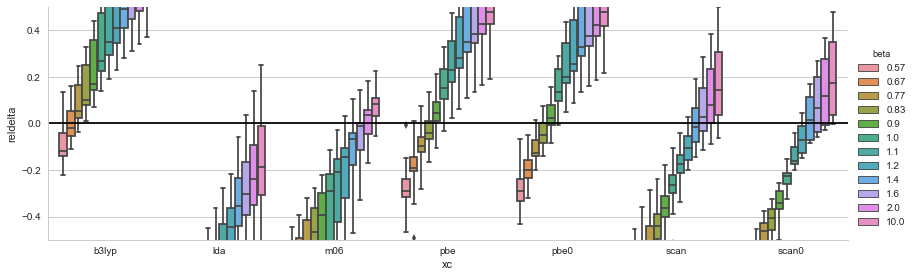

In [71]:
sns.factorplot(
    data=data.loc[(
        'X23',
        ['pbe',
         'pbe0',
         'scan',
         'scan0',
         'lda',
         'm06-light',
         'b3lyp'],
        slice(None),
        slice(None),
        6,
        [.57, .67, .77, .83, .9, 1., 1.1, 1.2, 1.4, 1.6, 2., 10.],
    ), :].reset_index().replace({'m06-light': 'm06'}),
    kind='box',
    x='xc',
    y='reldelta',
    hue='beta',
    whis=2.5,
    aspect=3,
)
sns.plt.ylim(-.5, .5)
sns.plt.axhline(color='black')
savefig()

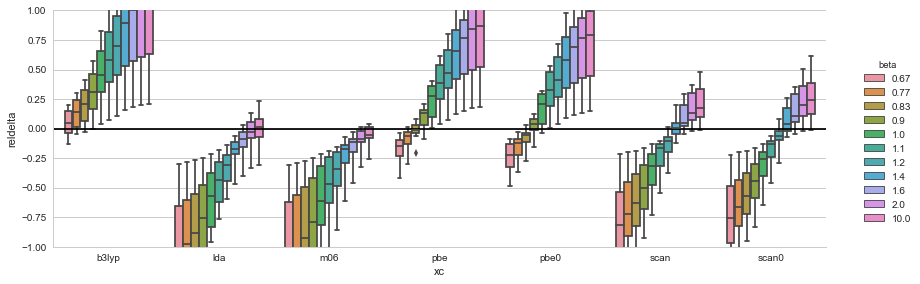

In [72]:
sns.factorplot(
    data=data.loc[(
        'S12L',
        ['pbe',
         'pbe0',
         'scan',
         'scan0',
         'lda',
         'm06-light',
         'b3lyp'],
        slice(None),
        slice(None),
        6,
        [.67, .77, .83, .9, 1., 1.1, 1.2, 1.4, 1.6, 2., 10.],
    ), :].reset_index().replace({'m06-light': 'm06'}),
    kind='box',
    x='xc',
    y='reldelta',
    hue='beta',
    whis=2.5,
    aspect=3,
    margin_titles=True
)
sns.plt.ylim(-1, 1)
sns.plt.axhline(color='black')
savefig()

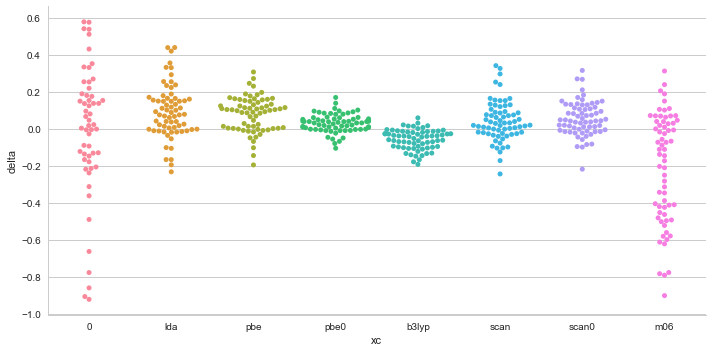

In [73]:
def replace_ref(df):
    df = df.copy()
    df['xc'] = '0'
    df['delta'] = df['ref']
    return df

sns.factorplot(
    data=pd.concat([
        data.loc[(
            '3B-69',
            ['pbe', 'pbe0', 'scan', 'scan0', 'lda', 'm06', 'b3lyp'],
            slice(None),
            slice(None),
            6,
            10.
        )].reset_index(),
        data.loc[(
            '3B-69', 'pbe', slice(None), slice(None), 6, 10.
        )].reset_index().pipe(replace_ref)
    ]).loc[lambda x: (x['delta'] > -1) & (x['delta'] < .6)],
    kind='swarm',
    x='xc',
    y='delta',
    order='0 lda pbe pbe0 b3lyp scan scan0 m06'.split(),
    split=True,
    size=5,
    aspect=2
)
sns.plt.savefig('/Users/hermann/Downloads/tmp.pdf')

In [74]:
def get_optimal_beta(df):
    df = df.groupby(level='beta').apply(get_stat).reset_index()
    mean = interp1d(df['beta'], df['mean'], kind='cubic')
    std = interp1d(df['beta'], df['STD'], kind='cubic')
    mare = interp1d(df['beta'], df['MARE'], kind='cubic')
    mae = interp1d(df['beta'], df['MAE'], kind='cubic')
    res = minimize(mare, 1., bounds=[(df['beta'].min(), df['beta'].min())])
    bounds = [(df['beta'].min()+1e-6, df['beta'].max()-1e-6)]
    opt_std = minimize(std, 1.6, bounds=bounds).x[0]
    opt_mean = brentq(mean, *bounds[0]) \
            if np.sign(mean(bounds[0][0])) != np.sign(mean(bounds[0][1])) \
            else bounds[0][1]
    opt_mare = minimize(mare, 1.6, bounds=bounds).x[0]
    opt_mae = minimize(mae, 1.6, bounds=bounds).x[0]
    return pd.Series({
        (q1, q2): np.round(fnc(val), 2)
        for q1, val in zip('mean STD MARE'.split(), [opt_mean, opt_std, opt_mare])
        for q2, fnc in zip('beta mean STD MARE MAE'.split(), [lambda x: x, mean, std, mare, mae])
    })

colors = {'MAE': 'blue', 'MARE': 'green', 'beta': 'blac', 'mean': 'red', 'STD': 'violet'}

def styler(col):
    return len(col)*[f'color: {colors[col.name[1]]}']
    
data.loc[(
    slice(None, 'X40x10'),
    ['pbe', 'scan', 'm06', 'b3lyp', 'pbe0', 'lda'],
    slice(None),
    slice(None),
    6,
    slice(None, 2.)
), :].groupby(level='xc name'.split()) \
.apply(get_optimal_beta).style.apply(styler)

(-0.7, 0.1)

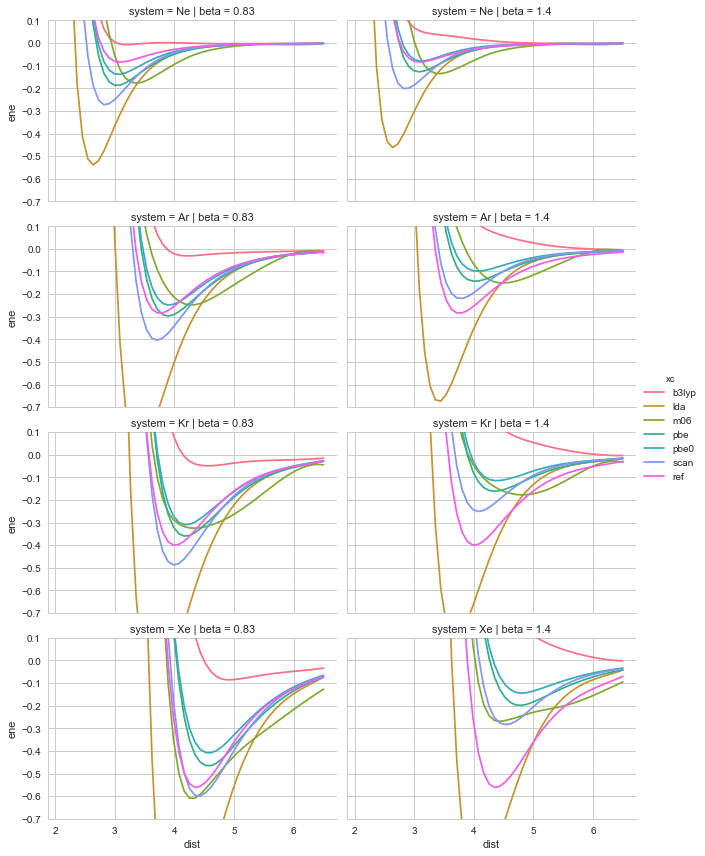

In [75]:
def replace_ref(df):
    df = df.copy()
    df['xc'] = 'ref'
    df['ene'] = df['ref']
    return df

def plot_curve(x, y, **kwargs):
    yinp  = interp1d(x, y, kind='cubic')
    xfine = np.linspace(x.min(), x.max())
    sns.plt.plot(xfine, yinp(xfine), **kwargs)
    
sns.FacetGrid(
    data=pd.concat([
        data.loc[(
            'rare-gas',
            ['pbe', 'pbe0', 'scan', 'm06', 'lda', 'b3lyp'],
            slice(None),
            slice(None, 7.),
            6,
            [.83, 1.4]
        ), :].reset_index(),
        data.loc[(
            'rare-gas', 'pbe', slice(None), slice(None, 7.), 6,
            [.83, 1.4]
        )].reset_index().pipe(replace_ref)
    ]),
    col='beta',
    row='system',
    row_order=['Ne', 'Ar', 'Kr', 'Xe'],
    hue='xc',
    aspect=1.5,
).map(plot_curve, 'dist', 'ene').add_legend()
sns.plt.ylim(-.7, .1)

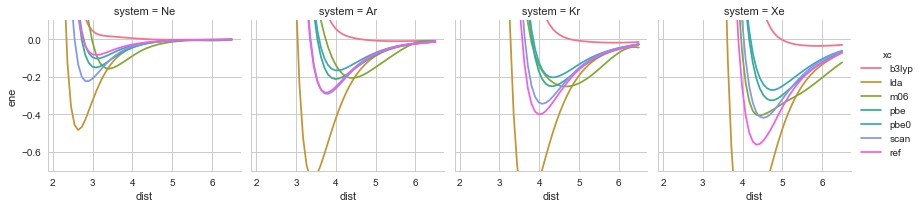

In [76]:
def replace_ref(df):
    df = df.copy()
    df['xc'] = 'ref'
    df['ene'] = df['ref']
    return df

sns.FacetGrid(
    data=pd.concat([
        data.loc[(
            'rare-gas',
            ['pbe', 'pbe0', 'scan', 'm06', 'lda', 'b3lyp'],
            slice(None),
            slice(None, 7.),
            6, 1.
        ), :].reset_index(),
        data.loc[(
            'rare-gas', 'pbe', slice(None), slice(None, 7.), 6, .83
        ), :].reset_index().pipe(replace_ref)
    ]),
    col='system',
    col_order=['Ne', 'Ar', 'Kr', 'Xe'],
    hue='xc'
).map(plot_curve, 'dist', 'ene').add_legend()
sns.plt.ylim(-.7, .1)
savefig()

In [77]:
data.loc[(
    'L7',
    ['pbe', 'pbe0', 'scan', 'm06', 'lda', 'b3lyp'],
    slice(None),
    slice(None),
    6,
    10.
), :].groupby(level='xc').apply(get_stat)

MAE      MARE       STD      mean
xc                                            
b3lyp  22.824454  1.596630  0.985348  1.596630
lda     6.102576  0.355163  0.315043  0.286323
m06     6.880348  0.487029  0.343141  0.487029
pbe    18.538875  1.253420  0.729949  1.253420
pbe0   17.986207  1.244114  0.761086  1.244114
scan    8.441675  0.547752  0.276054  0.547752

In [59]:
data.loc[(
    'X23',
    ['pbe', 'pbe0', 'pbe-light', 'pbe0-light'],
    slice(None),
    slice(None),
    6,
    10.
), 'ene_scf'].unstack(1).assign(
    delta_light=lambda x: x['pbe0-light']-x['pbe-light'],
    delta_tight=lambda x: x['pbe0']-x['pbe'],
).loc[:, ['delta_light', 'delta_tight']]

xc                           delta_light  delta_tight
name system     dist a beta                          
X23  CO2        1.0  6 10.0    -0.260755    -0.389137
     acetic     1.0  6 10.0    -0.451928          NaN
     adaman     1.0  6 10.0    -1.456989          NaN
     ammonia    1.0  6 10.0     0.545904          NaN
     anthracene 1.0  6 10.0    -2.365009    -1.012181
     benzene    1.0  6 10.0    -1.174269    -0.654381
     cyanamide  1.0  6 10.0     0.656191     0.457410
     cytosine   1.0  6 10.0    -1.443589    -1.021539
     ethcar     1.0  6 10.0    -0.658096    -0.403294
     formamide  1.0  6 10.0    -0.168228          NaN
     hexamine   1.0  6 10.0    -1.056355          NaN
     hexdio     1.0  6 10.0    -1.573987          NaN
     imdazole   1.0  6 10.0    -0.396638    -0.134897
     naph       1.0  6 10.0    -2.267187    -1.250639
     oxaca      1.0  6 10.0    -1.357603    -1.090708
     oxacb      1.0  6 10.0    -0.698536    -0.510504
     pyrazine   1.0  6 10.0    -0.796027    -0.373692
     pyrazole   1.0  6 10.0    -0.332464    -0.121596
     succinic   1.0  6 10.0    -0.599285          NaN
     triazine   1.0  6 10.0    -1.094046    -0.587366
     trioxane   1.0  6 10.0    -1.098511          NaN
     uracil     1.0  6 10.0    -1.422592          NaN
     urea       1.0  6 10.0    -0.400888    -0.640337

## D3 (BJ)

In [76]:
def cross_join(df, name, col):
    return df.assign(_key=0).merge(pd.DataFrame({name: col, '_key': 0}), on='_key').drop('_key', axis=1)

In [77]:
def merge_scf_vdw(baseidx, scf, scfidx, vdw, vdwidx, params):
    data = pd.merge(
        scf.loc[baseidx + scfidx, :].reset_index(),
        vdw.loc[baseidx + vdwidx, :].reset_index(),
        on='name system dist'.split(),
        how='inner',
        suffixes=('_scf', '_vdw')
    )
    data.set_index('name xc system dist'.split() + params, inplace=True)
    data['ene'] = data['ene_scf']+data['ene_vdw']
    data['delta'] = data['ene']-data['ref']
    data['reldelta'] = data['delta']/data['base']
    return data

In [78]:
data_scf.index.names, data_dftd3_bj.index.names

(FrozenList(['name', 'system', 'dist', 'xc']),
 FrozenList(['name', 'system', 'dist', 'a1', 'a2', 's8']))

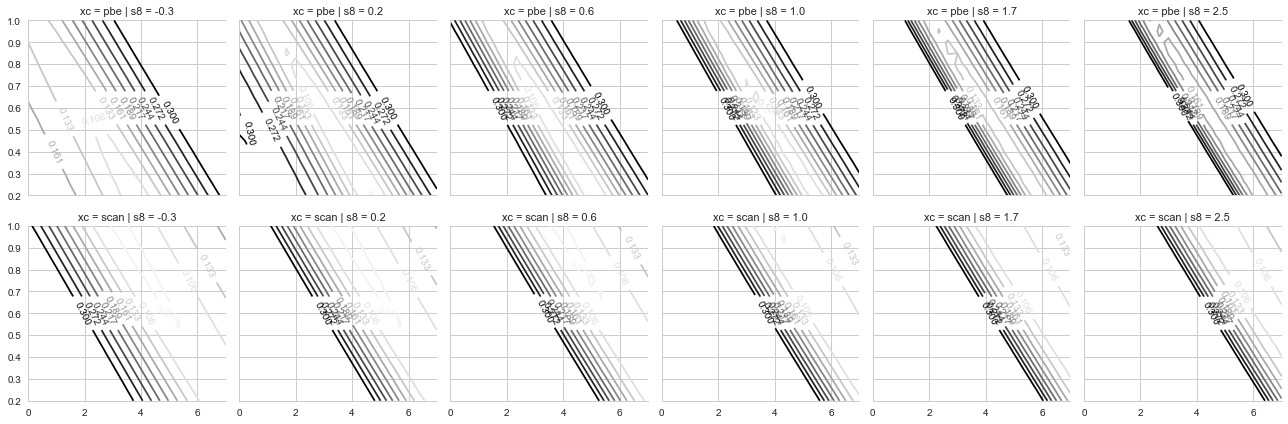

In [17]:
def plot_stat(**kwargs):
    df = kwargs.pop('data').groupby('a1 a2'.split()).apply(get_stat)
    df = df.reset_index().pivot(index='a1', columns='a2', values='STD')
    mare = df.as_matrix()
    p = sns.plt.contour(df.columns, df.index, mare, np.linspace(0.05, 0.3, 10))
    sns.plt.clabel(p, inline=1)

g = sns.FacetGrid(
    merge_scf_vdw(
        ('S66x8', slice(None), slice(None)),
        data_scf, (['pbe', 'scan'],),
        data_dftd3_bj, (slice(None), slice(None, 7.), slice(None, None, 2)),
        'a1 a2 s8'.split()
    ).reset_index(),
    col='s8',
    row='xc'
).map_dataframe(plot_stat)
# g.fig.legend(
#     (line1, line2), ('mean', 'standard deviation'),
#     loc='lower center', bbox_to_anchor=(.7, 0), ncol=2
# )
# g.fig.subplots_adjust(bottom=0.16, left=0.2, right=.93)
# sns.plt.ylim(-.4, .4)
# g.set_xlabels(r'$\beta$')
# g.set_ylabels(r'$\Delta E/E_\mathrm{ref}$')
# xticks = [.6, .8, 1, 1.2, 1.4]
# yticks = [-.3, 0, .3]
# g.set(xticks=xticks, yticks=yticks)
# g.set_xticklabels(xticks)
# g.set_yticklabels(['-30%', '0%', '30%'])
# savefig()

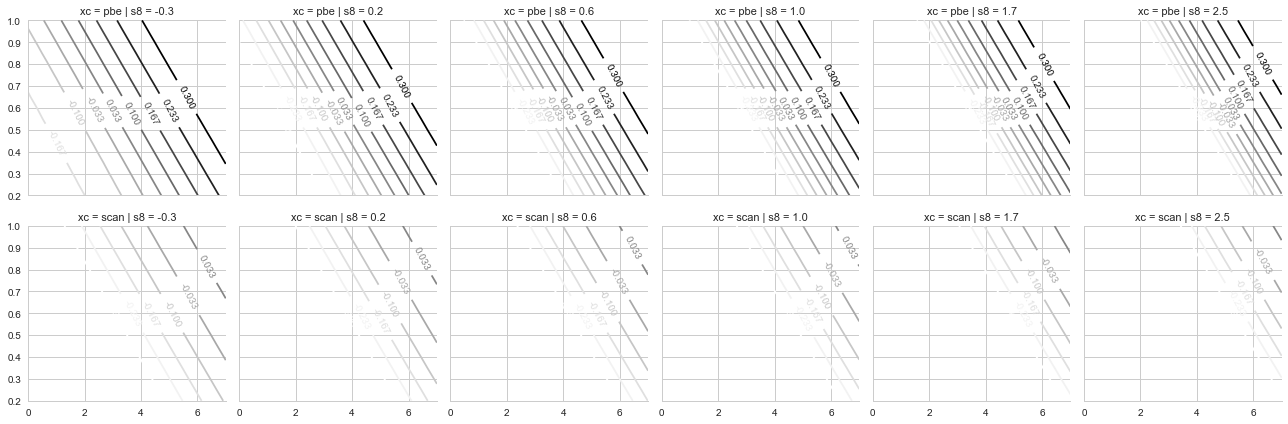

In [15]:
def plot_stat(**kwargs):
    df = kwargs.pop('data').groupby('a1 a2'.split()).apply(get_stat)
    df = df.reset_index().pivot(index='a1', columns='a2', values='mean')
    mat = df.as_matrix()
    p = sns.plt.contour(df.columns, df.index, mat, np.linspace(-.3, .3, 10))
    sns.plt.clabel(p, inline=1)

g = sns.FacetGrid(
    merge_scf_vdw(
        ('S66x8', slice(None), slice(None)),
        data_scf, (['pbe', 'scan'],),
        data_dftd3_bj, (slice(None), slice(None, 7.), slice(None, None, 2)),
        'a1 a2 s8'.split()
    ).reset_index(),
    col='s8',
    row='xc'
).map_dataframe(plot_stat)
# g.fig.legend(
#     (line1, line2), ('mean', 'standard deviation'),
#     loc='lower center', bbox_to_anchor=(.7, 0), ncol=2
# )
# g.fig.subplots_adjust(bottom=0.16, left=0.2, right=.93)
# sns.plt.ylim(-.4, .4)
# g.set_xlabels(r'$\beta$')
# g.set_ylabels(r'$\Delta E/E_\mathrm{ref}$')
# xticks = [.6, .8, 1, 1.2, 1.4]
# yticks = [-.3, 0, .3]
# g.set(xticks=xticks, yticks=yticks)
# g.set_xticklabels(xticks)
# g.set_yticklabels(['-30%', '0%', '30%'])
# savefig()

In [50]:
data_dftd3_bj.reset_index().s8.unique()

array([-0.3,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.3,  1.7,  2. ,  2.5,
        3. ])

(-0.4, 0.4)

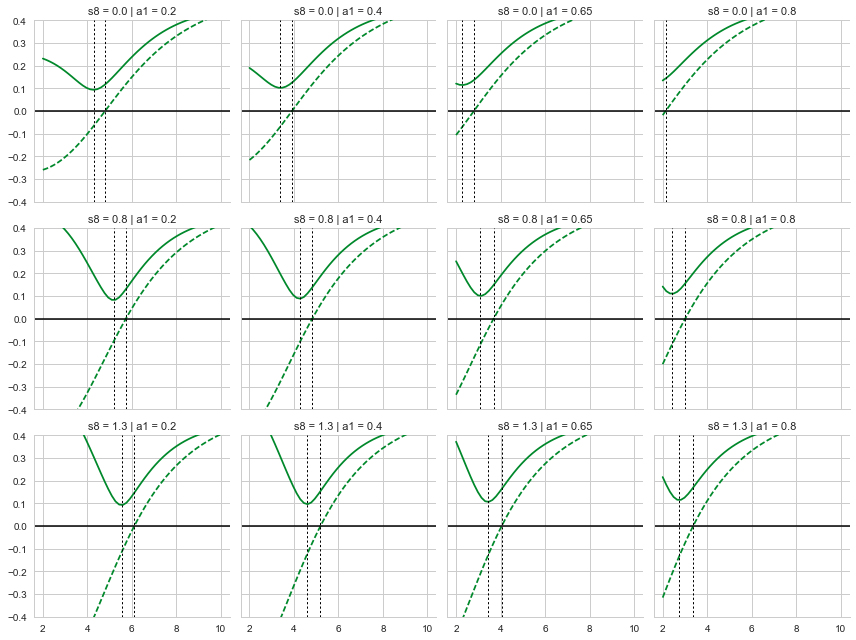

In [166]:
def plot_stat(**kwargs):
    df = kwargs.pop('data')
    df = df.groupby('a2').apply(get_stat).reset_index()
    mean = interp1d(df['a2'], df['mean'], kind='cubic')
    std = interp1d(df['a2'], df['STD'], kind='cubic')
    a2 = np.linspace(df['a2'].min(), df['a2'].max())
    line1, = sns.plt.plot(a2, mean(a2), '--', color='#00882B')
    line2, = sns.plt.plot(a2, std(a2), '-', color='#00882B')
    sns.plt.axhline(color='black', lw=1.5)
    bounds = [(df['a2'].min()+1e-6, df['a2'].max()-1e-6)]
    opt_std = minimize(std, 4., bounds=bounds).x[0]
    if bounds[0][0] < opt_std < bounds[0][1]:
        sns.plt.axvline(opt_std, color='black', ls='dotted', lw=1)
    if np.sign(mean(bounds[0][0])) != np.sign(mean(bounds[0][1])):
        opt_mean = brentq(mean, *bounds[0])
        sns.plt.axvline(opt_mean, color='black', ls='dotted', lw=1)

g = sns.FacetGrid(
    merge_scf_vdw(
        ('S66x8', slice(None), slice(None)),
        data_scf, (['pbe'],),
        data_dftd3_bj, ([.2, .4, .65, .8], slice(2., 11.), [0., .8, 1.3]),
        'a1 a2 s8'.split()
    ).reset_index(),
    row='s8',
    col='a1'
).map_dataframe(plot_stat)
sns.plt.ylim(-.4, .4)

In [98]:
def subtract_abc(df):
    df = df.copy()
    df['ene'] = df['ene']-df['ene3']
    return df

(-0.4, 0.4)

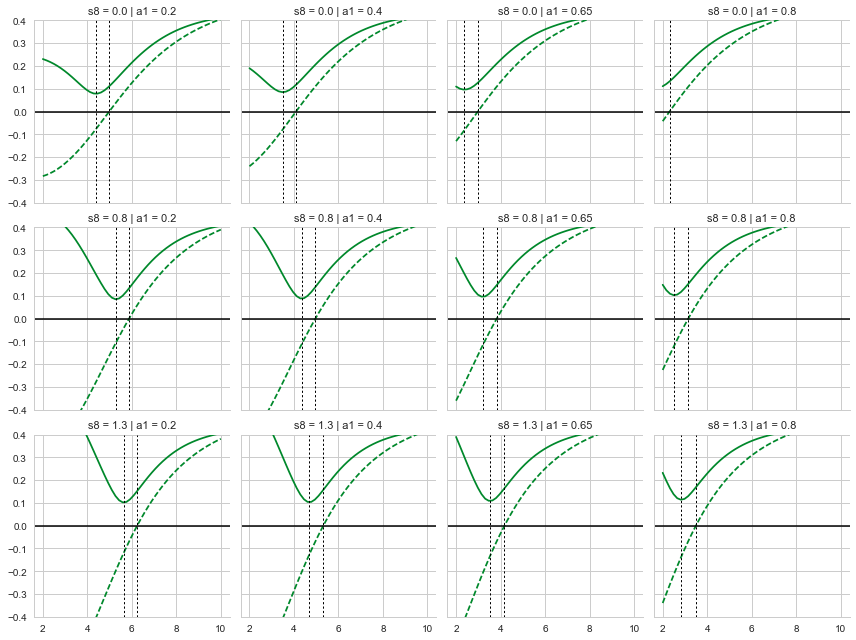

In [102]:
def plot_stat(**kwargs):
    df = kwargs.pop('data')
    df = df.groupby('a2').apply(get_stat).reset_index()
    mean = interp1d(df['a2'], df['mean'], kind='cubic')
    std = interp1d(df['a2'], df['STD'], kind='cubic')
    a2 = np.linspace(df['a2'].min(), df['a2'].max())
    line1, = sns.plt.plot(a2, mean(a2), '--', color='#00882B')
    line2, = sns.plt.plot(a2, std(a2), '-', color='#00882B')
    sns.plt.axhline(color='black', lw=1.5)
    bounds = [(df['a2'].min()+1e-6, df['a2'].max()-1e-6)]
    opt_std = minimize(std, 4., bounds=bounds).x[0]
    if bounds[0][0] < opt_std < bounds[0][1]:
        sns.plt.axvline(opt_std, color='black', ls='dotted', lw=1)
    if np.sign(mean(bounds[0][0])) != np.sign(mean(bounds[0][1])):
        opt_mean = brentq(mean, *bounds[0])
        sns.plt.axvline(opt_mean, color='black', ls='dotted', lw=1)

g = sns.FacetGrid(
    merge_scf_vdw(
        ('S66x8', slice(None), slice(None)),
        data_scf, (['pbe'],),
        data_dftd3_bj.pipe(subtract_abc), ([.2, .4, .65, .8], slice(2., 11.), [0., .8, 1.3]),
        'a1 a2 s8'.split()
    ).reset_index(),
    row='s8',
    col='a1'
).map_dataframe(plot_stat)
sns.plt.ylim(-.4, .4)

(-0.4, 0.4)

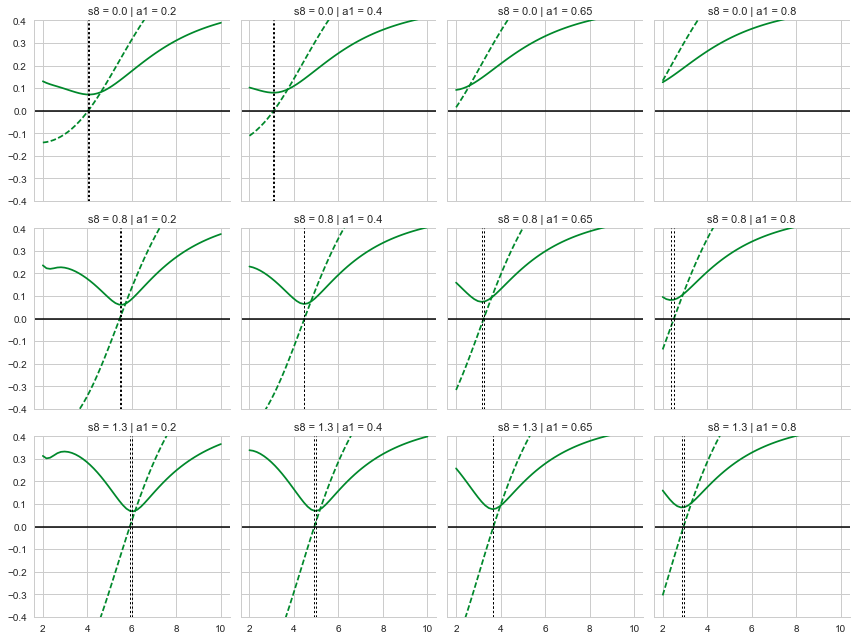

In [103]:
def plot_stat(**kwargs):
    df = kwargs.pop('data').groupby('a2').apply(get_stat).reset_index()
    mean = interp1d(df['a2'], df['mean'], kind='cubic')
    std = interp1d(df['a2'], df['STD'], kind='cubic')
    a2 = np.linspace(df['a2'].min(), df['a2'].max())
    line1, = sns.plt.plot(a2, mean(a2), '--', color='#00882B')
    line2, = sns.plt.plot(a2, std(a2), '-', color='#00882B')
    sns.plt.axhline(color='black', lw=1.5)
    bounds = [(df['a2'].min()+1e-6, df['a2'].max()-1e-6)]
    opt_std = minimize(std, 4., bounds=bounds).x[0]
    if bounds[0][0] < opt_std < bounds[0][1]:
        sns.plt.axvline(opt_std, color='black', ls='dotted', lw=1)
    if np.sign(mean(bounds[0][0])) != np.sign(mean(bounds[0][1])):
        opt_mean = brentq(mean, *bounds[0])
        sns.plt.axvline(opt_mean, color='black', ls='dotted', lw=1)


g = sns.FacetGrid(
    merge_scf_vdw(
        ('S12L', slice(None), slice(None)),
        data_scf, (['pbe'],),
        data_dftd3_bj, ([.2, .4, .65, .8], slice(2., 11.), [0., .8, 1.3]),
        'a1 a2 s8'.split()
    ).reset_index(),
    row='s8',
    col='a1'
).map_dataframe(plot_stat)
sns.plt.ylim(-.4, .4)

(-0.4, 0.4)

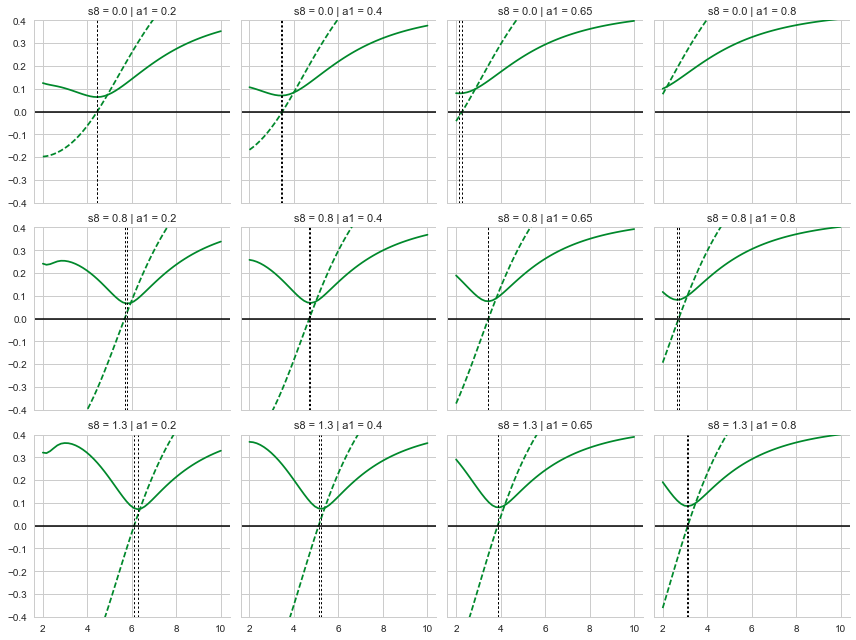

In [104]:
def plot_stat(**kwargs):
    df = kwargs.pop('data').groupby('a2').apply(get_stat).reset_index()
    mean = interp1d(df['a2'], df['mean'], kind='cubic')
    std = interp1d(df['a2'], df['STD'], kind='cubic')
    a2 = np.linspace(df['a2'].min(), df['a2'].max())
    line1, = sns.plt.plot(a2, mean(a2), '--', color='#00882B')
    line2, = sns.plt.plot(a2, std(a2), '-', color='#00882B')
    sns.plt.axhline(color='black', lw=1.5)
    bounds = [(df['a2'].min()+1e-6, df['a2'].max()-1e-6)]
    opt_std = minimize(std, 4., bounds=bounds).x[0]
    if bounds[0][0] < opt_std < bounds[0][1]:
        sns.plt.axvline(opt_std, color='black', ls='dotted', lw=1)
    if np.sign(mean(bounds[0][0])) != np.sign(mean(bounds[0][1])):
        opt_mean = brentq(mean, *bounds[0])
        sns.plt.axvline(opt_mean, color='black', ls='dotted', lw=1)


g = sns.FacetGrid(
    merge_scf_vdw(
        ('S12L', slice(None), slice(None)),
        data_scf, (['pbe'],),
        data_dftd3_bj.pipe(subtract_abc), ([.2, .4, .65, .8], slice(2., 11.), [0., .8, 1.3]),
        'a1 a2 s8'.split()
    ).reset_index(),
    row='s8',
    col='a1'
).map_dataframe(plot_stat)
sns.plt.ylim(-.4, .4)

(-0.4, 0.4)

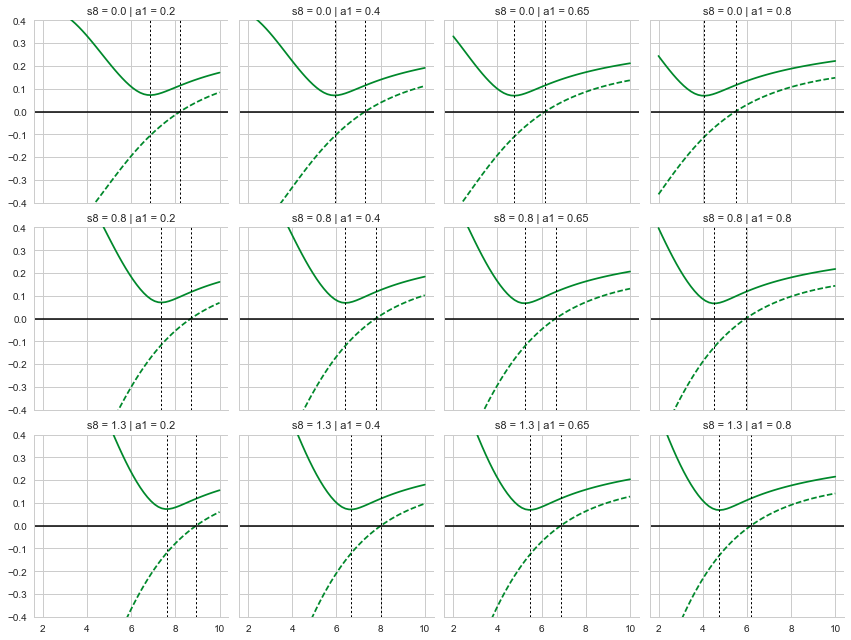

In [107]:
def plot_stat(**kwargs):
    df = kwargs.pop('data').groupby('a2').apply(get_stat).reset_index()
    mean = interp1d(df['a2'], df['mean'], kind='cubic')
    std = interp1d(df['a2'], df['STD'], kind='cubic')
    a2 = np.linspace(df['a2'].min(), df['a2'].max())
    line1, = sns.plt.plot(a2, mean(a2), '--', color='#00882B')
    line2, = sns.plt.plot(a2, std(a2), '-', color='#00882B')
    sns.plt.axhline(color='black', lw=1.5)
    bounds = [(df['a2'].min()+1e-6, df['a2'].max()-1e-6)]
    opt_std = minimize(std, 4., bounds=bounds).x[0]
    if bounds[0][0] < opt_std < bounds[0][1]:
        sns.plt.axvline(opt_std, color='black', ls='dotted', lw=1)
    if np.sign(mean(bounds[0][0])) != np.sign(mean(bounds[0][1])):
        opt_mean = brentq(mean, *bounds[0])
        sns.plt.axvline(opt_mean, color='black', ls='dotted', lw=1)

g = sns.FacetGrid(
    merge_scf_vdw(
        ('S66x8', slice(None), slice(None)),
        data_scf, (['scan'],),
        data_dftd3_bj, ([.2, .4, .65, .8], slice(2., 11.), [0., .8, 1.3]),
        'a1 a2 s8'.split()
    ).reset_index(),
    row='s8',
    col='a1'
).map_dataframe(plot_stat)
sns.plt.ylim(-.4, .4)

(-0.4, 0.4)

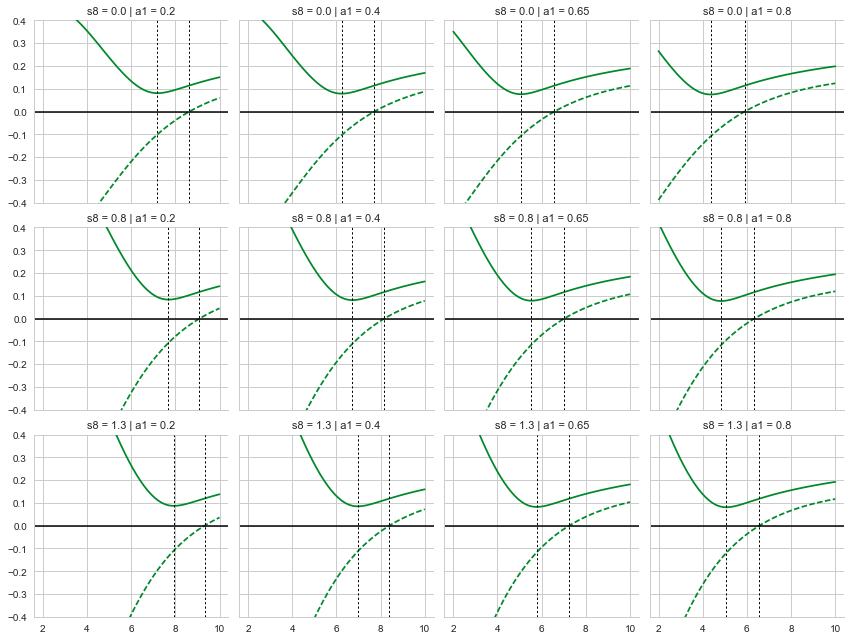

In [106]:
def plot_stat(**kwargs):
    df = kwargs.pop('data').groupby('a2').apply(get_stat).reset_index()
    mean = interp1d(df['a2'], df['mean'], kind='cubic')
    std = interp1d(df['a2'], df['STD'], kind='cubic')
    a2 = np.linspace(df['a2'].min(), df['a2'].max())
    line1, = sns.plt.plot(a2, mean(a2), '--', color='#00882B')
    line2, = sns.plt.plot(a2, std(a2), '-', color='#00882B')
    sns.plt.axhline(color='black', lw=1.5)
    bounds = [(df['a2'].min()+1e-6, df['a2'].max()-1e-6)]
    opt_std = minimize(std, 4., bounds=bounds).x[0]
    if bounds[0][0] < opt_std < bounds[0][1]:
        sns.plt.axvline(opt_std, color='black', ls='dotted', lw=1)
    if np.sign(mean(bounds[0][0])) != np.sign(mean(bounds[0][1])):
        opt_mean = brentq(mean, *bounds[0])
        sns.plt.axvline(opt_mean, color='black', ls='dotted', lw=1)

g = sns.FacetGrid(
    merge_scf_vdw(
        ('S66x8', slice(None), slice(None)),
        data_scf, (['scan'],),
        data_dftd3_bj.pipe(subtract_abc), ([.2, .4, .65, .8], slice(2., 11.), [0., .8, 1.3]),
        'a1 a2 s8'.split()
    ).reset_index(),
    row='s8',
    col='a1'
).map_dataframe(plot_stat)
sns.plt.ylim(-.4, .4)

(-0.4, 0.4)

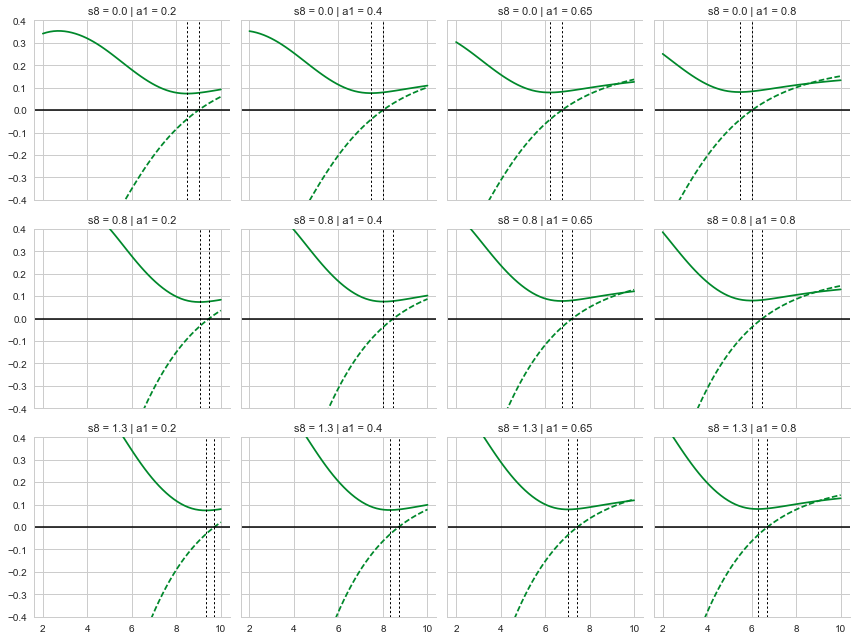

In [69]:
def plot_stat(**kwargs):
    df = kwargs.pop('data').groupby('a2').apply(get_stat).reset_index()
    mean = interp1d(df['a2'], df['mean'], kind='cubic')
    std = interp1d(df['a2'], df['STD'], kind='cubic')
    a2 = np.linspace(df['a2'].min(), df['a2'].max())
    line1, = sns.plt.plot(a2, mean(a2), '--', color='#00882B')
    line2, = sns.plt.plot(a2, std(a2), '-', color='#00882B')
    sns.plt.axhline(color='black', lw=1.5)
    bounds = [(df['a2'].min()+1e-6, df['a2'].max()-1e-6)]
    opt_std = minimize(std, 4., bounds=bounds).x[0]
    if bounds[0][0] < opt_std < bounds[0][1]:
        sns.plt.axvline(opt_std, color='black', ls='dotted', lw=1)
    if np.sign(mean(bounds[0][0])) != np.sign(mean(bounds[0][1])):
        opt_mean = brentq(mean, *bounds[0])
        sns.plt.axvline(opt_mean, color='black', ls='dotted', lw=1)

g = sns.FacetGrid(
    merge_scf_vdw(
        ('S12L', slice(None), slice(None)),
        data_scf, (['scan'],),
        data_dftd3_bj, ([.2, .4, .65, .8], slice(2., 11.), [0., .8, 1.3]),
        'a1 a2 s8'.split()
    ).reset_index(),
    row='s8',
    col='a1'
).map_dataframe(plot_stat)
sns.plt.ylim(-.4, .4)

(-0.4, 0.4)

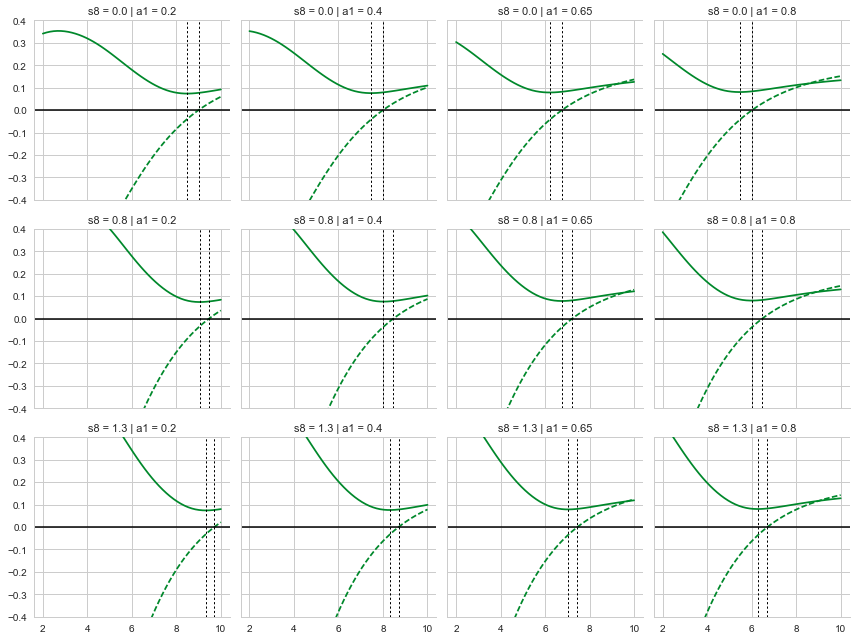

In [108]:
def plot_stat(**kwargs):
    df = kwargs.pop('data').groupby('a2').apply(get_stat).reset_index()
    mean = interp1d(df['a2'], df['mean'], kind='cubic')
    std = interp1d(df['a2'], df['STD'], kind='cubic')
    a2 = np.linspace(df['a2'].min(), df['a2'].max())
    line1, = sns.plt.plot(a2, mean(a2), '--', color='#00882B')
    line2, = sns.plt.plot(a2, std(a2), '-', color='#00882B')
    sns.plt.axhline(color='black', lw=1.5)
    bounds = [(df['a2'].min()+1e-6, df['a2'].max()-1e-6)]
    opt_std = minimize(std, 4., bounds=bounds).x[0]
    if bounds[0][0] < opt_std < bounds[0][1]:
        sns.plt.axvline(opt_std, color='black', ls='dotted', lw=1)
    if np.sign(mean(bounds[0][0])) != np.sign(mean(bounds[0][1])):
        opt_mean = brentq(mean, *bounds[0])
        sns.plt.axvline(opt_mean, color='black', ls='dotted', lw=1)

g = sns.FacetGrid(
    merge_scf_vdw(
        ('S12L', slice(None), slice(None)),
        data_scf, (['scan'],),
        data_dftd3_bj.pipe(subtract_abc), ([.2, .4, .65, .8], slice(2., 11.), [0., .8, 1.3]),
        'a1 a2 s8'.split()
    ).reset_index(),
    row='s8',
    col='a1'
).map_dataframe(plot_stat)
sns.plt.ylim(-.4, .4)

(-0.4, 0.4)

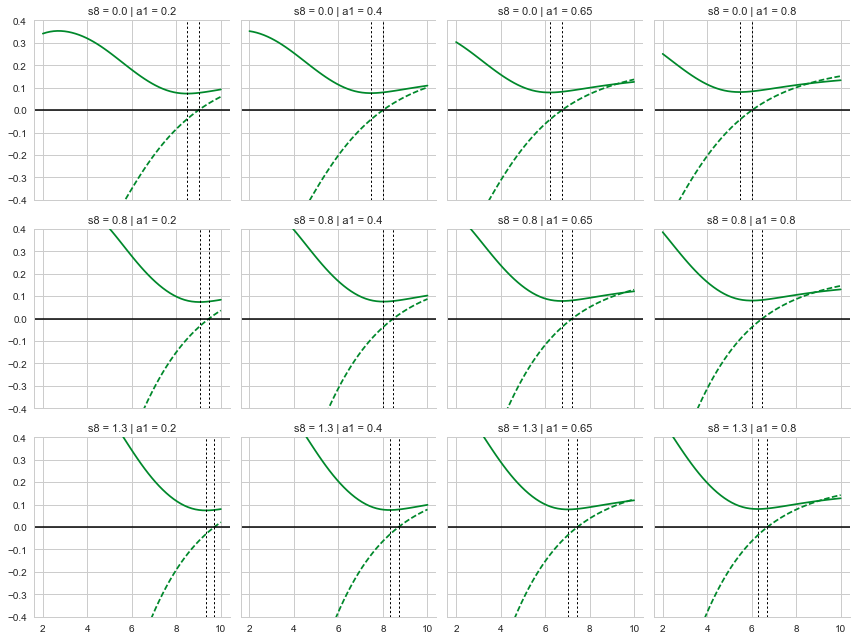

In [69]:
def plot_stat(**kwargs):
    df = kwargs.pop('data').groupby('a2').apply(get_stat).reset_index()
    mean = interp1d(df['a2'], df['mean'], kind='cubic')
    std = interp1d(df['a2'], df['STD'], kind='cubic')
    a2 = np.linspace(df['a2'].min(), df['a2'].max())
    line1, = sns.plt.plot(a2, mean(a2), '--', color='#00882B')
    line2, = sns.plt.plot(a2, std(a2), '-', color='#00882B')
    sns.plt.axhline(color='black', lw=1.5)
    bounds = [(df['a2'].min()+1e-6, df['a2'].max()-1e-6)]
    opt_std = minimize(std, 4., bounds=bounds).x[0]
    if bounds[0][0] < opt_std < bounds[0][1]:
        sns.plt.axvline(opt_std, color='black', ls='dotted', lw=1)
    if np.sign(mean(bounds[0][0])) != np.sign(mean(bounds[0][1])):
        opt_mean = brentq(mean, *bounds[0])
        sns.plt.axvline(opt_mean, color='black', ls='dotted', lw=1)

g = sns.FacetGrid(
    merge_scf_vdw(
        ('S12L', slice(None), slice(None)),
        data_scf, (['scan'],),
        data_dftd3_bj, ([.2, .4, .65, .8], slice(2., 11.), [0., .8, 1.3]),
        'a1 a2 s8'.split()
    ).reset_index(),
    row='s8',
    col='a1'
).map_dataframe(plot_stat)
sns.plt.ylim(-.4, .4)

(-0.4, 0.4)

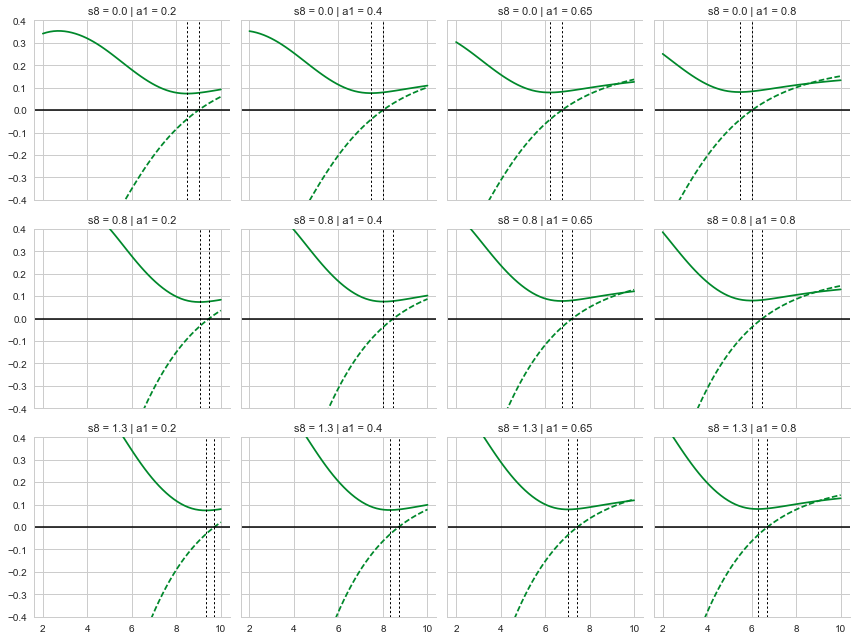

In [69]:
def plot_stat(**kwargs):
    df = kwargs.pop('data').groupby('a2').apply(get_stat).reset_index()
    mean = interp1d(df['a2'], df['mean'], kind='cubic')
    std = interp1d(df['a2'], df['STD'], kind='cubic')
    a2 = np.linspace(df['a2'].min(), df['a2'].max())
    line1, = sns.plt.plot(a2, mean(a2), '--', color='#00882B')
    line2, = sns.plt.plot(a2, std(a2), '-', color='#00882B')
    sns.plt.axhline(color='black', lw=1.5)
    bounds = [(df['a2'].min()+1e-6, df['a2'].max()-1e-6)]
    opt_std = minimize(std, 4., bounds=bounds).x[0]
    if bounds[0][0] < opt_std < bounds[0][1]:
        sns.plt.axvline(opt_std, color='black', ls='dotted', lw=1)
    if np.sign(mean(bounds[0][0])) != np.sign(mean(bounds[0][1])):
        opt_mean = brentq(mean, *bounds[0])
        sns.plt.axvline(opt_mean, color='black', ls='dotted', lw=1)

g = sns.FacetGrid(
    merge_scf_vdw(
        ('S12L', slice(None), slice(None)),
        data_scf, (['scan'],),
        data_dftd3_bj, ([.2, .4, .65, .8], slice(2., 11.), [0., .8, 1.3]),
        'a1 a2 s8'.split()
    ).reset_index(),
    row='s8',
    col='a1'
).map_dataframe(plot_stat)
sns.plt.ylim(-.4, .4)

In [17]:
def merge_scf_vdw_multi(baseidx, scf, scfidxs, vdw, vdwidxs, params):
    data = pd.merge(
        pd.concat(scf.loc[baseidx + idx, :] for idx in scfidxs).reset_index(),
        pd.concat(vdw.loc[baseidx + idx, :] for idx in vdwidxs).reset_index(),
        on='name system dist'.split(),
        how='inner',
        suffixes=('_scf', '_vdw')
    )
    data.set_index('name xc system dist'.split() + params, inplace=True)
    data['ene'] = data['ene_scf']+data['ene_vdw']
    data['delta'] = data['ene']-data['ref']
    data['reldelta'] = data['delta']/data['base']
    return data

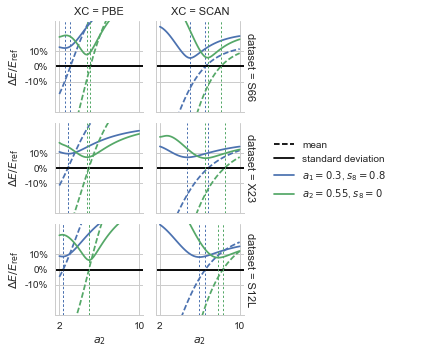

In [32]:
lines = {}

def plot_stat(**kwargs):
    df = kwargs.pop('data').groupby('a2').apply(get_stat).reset_index()
    color = kwargs.pop('color')
    mean = interp1d(df['a2'], df['mean'], kind='cubic')
    std = interp1d(df['a2'], df['STD'], kind='cubic')
    a2 = np.linspace(df['a2'].min(), df['a2'].max())
    lines['-', color], = sns.plt.plot(a2, mean(a2), '--', color=color)
    lines['--', color], = sns.plt.plot(a2, std(a2), '-', color=color)
    sns.plt.axhline(color='black', lw=1.5)
    bounds = [(df['a2'].min()+1e-6, df['a2'].max()-1e-6)]
    opt_std = minimize(std, 4., bounds=bounds).x[0]
    if bounds[0][0] < opt_std < bounds[0][1]:
        sns.plt.axvline(opt_std, color=color, ls='dotted', lw=1)
    if np.sign(mean(bounds[0][0])) != np.sign(mean(bounds[0][1])):
        opt_mean = brentq(mean, *bounds[0])
        sns.plt.axvline(opt_mean, color=color, ls='dotted', lw=1)
        
g = sns.FacetGrid(
    merge_scf_vdw_multi(
        (['S66x8', 'X23', 'S12L'], slice(None), 1.),
        data_scf, [(['pbe', 'scan'],)],
        data_dftd3_bj, [(.30000000000000004, slice(2., 11.), .8), (.55, slice(2., 11.), 0.)],
        'a1 a2 s8'.split()
    ).reset_index()
    .apply(normalize_names)
    .replace('S66x8', 'S66')
    .rename(columns={'xc': 'XC', 'name': 'dataset'}), 
    hue='s8',
    row='dataset',
    col='XC',
    size=1.6,
    row_order='S66 X23 S12L'.split(),
    margin_titles=True
).map_dataframe(plot_stat)

lines = list(lines.values())
lines = [copy(lines[i]) for i in [0, 1, 1, 3]]
lines[0].set_color('black')
lines[1].set_color('black')
lgnd = g.fig.legend(
    lines,
    ('mean', 'standard deviation', '$a_1=0.3$, $s_8=0.8$', '$a_2=0.55$, $s_8=0$'),
    loc='center left', bbox_to_anchor=(1.15, .53), ncol=1
)
# g.fig.subplots_adjust(bottom=0.3, left=0.25, right=.6)
sns.plt.ylim(-.3, .3)
g.set_xlabels(r'$a_2$')
g.set_ylabels(r'$\Delta E/E_\mathrm{ref}$')
xticks = [2, 10]
yticks = [-.1, 0, .1]
g.set(xticks=xticks, yticks=yticks)
g.set_yticklabels(['-10%', '0%', '10%'])
savefig(bbox_inches='tight')

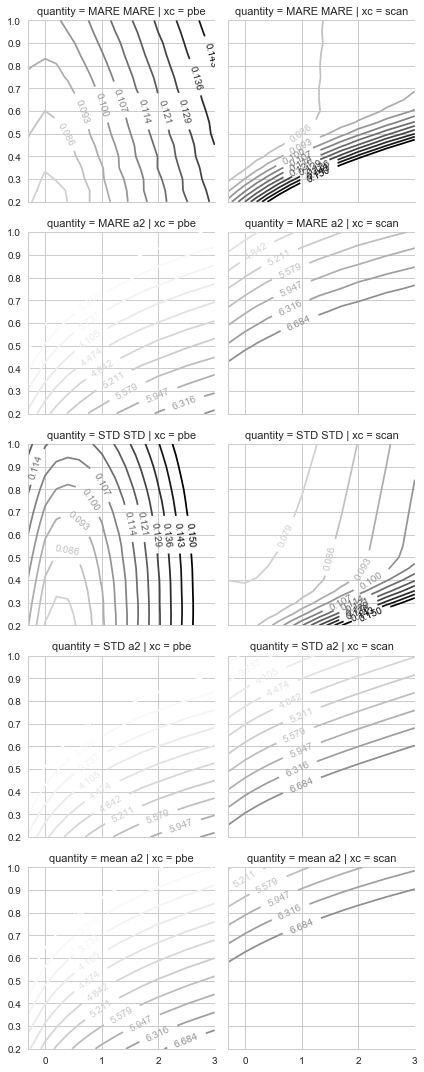

In [26]:
def get_opt(df, x, y):
    f = interp1d(df[x], df[y], kind='cubic')
    bounds = [(df[x].min()+1e-6, df[x].max()-1e-6)]
    if y == 'mean':
        if df[y].iloc[-1] > 0:
            xmin = brentq(f, *bounds[0])
        else:
            xmin = df[x].max()
    else:
        xmin = minimize(f, 4., bounds=bounds).x[0]
    return pd.Series({x: xmin, y: f(xmin)})
    
def plot_stat(**kwargs):
    df = kwargs.pop('data')
    target, var = df.quantity.iloc[0].split()
    df = df.groupby('a1 a2 s8'.split()).apply(get_stat)
    df = df[target].reset_index().groupby('a1 s8'.split()).apply(get_opt, 'a2', target)
    df = df.reset_index().pivot(index='a1', columns='s8', values=var)
    mat = df.as_matrix()
    if var in ['STD', 'MARE']:
        contours = np.linspace(0.05, 0.15, 15)
    elif var == 'a2':
        contours = np.linspace(3, 10, 20)
    p = sns.plt.contour(df.columns, df.index, mat, contours)
    sns.plt.clabel(p, inline=1)

g = sns.FacetGrid(
    cross_join(merge_scf_vdw(
        ('S66x8', slice(None), slice(None)),
        data_scf, (['scan', 'pbe'],),
        data_dftd3_bj, (slice(None), slice(None, 7.)),
        'a1 a2 s8'.split()
    ).reset_index(), 'quantity', ['MARE MARE', 'MARE a2', 'STD STD', 'STD a2', 'mean a2']),
    row='quantity',
    col='xc'
).map_dataframe(plot_stat)
# g.fig.legend(
#     (line1, line2), ('mean', 'standard deviation'),
#     loc='lower center', bbox_to_anchor=(.7, 0), ncol=2
# )
# g.fig.subplots_adjust(bottom=0.16, left=0.2, right=.93)
# sns.plt.ylim(-.4, .4)
# g.set_xlabels(r'$\beta$')
# g.set_ylabels(r'$\Delta E/E_\mathrm{ref}$')
# xticks = [.6, .8, 1, 1.2, 1.4]
# yticks = [-.3, 0, .3]
# g.set(xticks=xticks, yticks=yticks)
# g.set_xticklabels(xticks)
# g.set_yticklabels(['-30%', '0%', '30%'])
# savefig()

## D3 (zero)

In [8]:
data_scf.index.names, data_dftd3_0.index.names

(FrozenList(['name', 'system', 'dist', 'xc']),
 FrozenList(['name', 'system', 'dist', 'sr6', 'sr8', 's8', 'alpha']))

0.0940076806815 1.54647881042
0.0904608400645 1.38644495793
0.0846415823079 1.10903923201


/usr/local/lib/python3.6/site-packages/matplotlib/contour.py:370: RuntimeWarning: invalid value encountered in true_divide
  dist = np.add.reduce(([(abs(s)[i] / L[i]) for i in range(xsize)]), -1)


0.0970577810872 0.744407794638
0.102206614986 0.532832186444
0.101754200766 1.89189182655
0.0998605911747 1.73185797406
0.0944211749404 1.45445224814
0.0916473039384 1.08982081077
0.0888448555545 0.867553255131


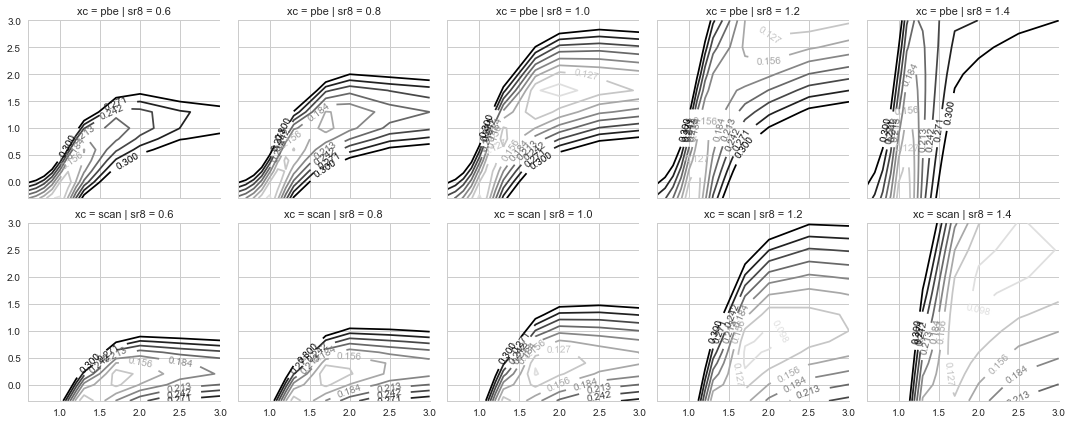

In [64]:
def plot_stat(**kwargs):
    df = kwargs.pop('data').groupby('sr6 s8'.split()).apply(get_stat)
    df = df.MARE.reset_index().pivot(columns='sr6', index='s8', values='MARE')
    mare = df.as_matrix()
    print(mare.min(), mare.max())
    p = sns.plt.contour(df.columns, df.index, mare, np.linspace(0.04, 0.3, 10))
    sns.plt.clabel(p, inline=1)

g = sns.FacetGrid(
    merge_scf_vdw(
        ('S66x8', slice(None), slice(None)),
        data_scf, (['pbe', 'scan'],),
        data_dftd3_0, (slice(None, 9.), slice(None), slice(None)),
        'sr6 sr8 s8'.split()
    ).reset_index(),
    col='sr8',
    row='xc'
).map_dataframe(plot_stat)
# g.fig.legend(
#     (line1, line2), ('mean', 'standard deviation'),
#     loc='lower center', bbox_to_anchor=(.7, 0), ncol=2
# )
# g.fig.subplots_adjust(bottom=0.16, left=0.2, right=.93)
# sns.plt.ylim(-.4, .4)
# g.set_xlabels(r'$\beta$')
# g.set_ylabels(r'$\Delta E/E_\mathrm{ref}$')
# xticks = [.6, .8, 1, 1.2, 1.4]
# yticks = [-.3, 0, .3]
# g.set(xticks=xticks, yticks=yticks)
# g.set_xticklabels(xticks)
# g.set_yticklabels(['-30%', '0%', '30%'])
# savefig()


In [78]:
def get_rows(df):
    sr = df.groupby(level='sr6 s8'.split()).apply(get_stat).MARE
    sr6_0, s8_0 = sr.idxmin()
    df = sr.reset_index().pivot(columns='sr6', index='s8', values='MARE')
    mare = df.as_matrix()
    f = interp2d(df.columns, df.index, mare, kind='cubic')
    bounds = [
        (df.columns.min()+1e-6, df.columns.max()-1e-6),
        (df.index.min()+1e-6, df.index.max()-1e-6),
    ]
    sr6_opt, s8_opt = minimize(
        lambda x: f(x[0], x[1]),
        (sr6_0, s8_0),
        bounds=bounds
    ).x
    return pd.Series({
        'MARE': f(sr6_opt, s8_opt)[0],
        's8': s8_opt,
        'sr6': sr6_opt,
        's80': s8_0,
        'sr60': sr6_0,
    })
    
merge_scf_vdw(
    ('S66x8', slice(None), slice(None)),
    data_scf, (['pbe', 'scan'],),
    data_dftd3_0, (slice(None, 9.), slice(None), slice(None)),
    'sr6 sr8 s8'.split()
).groupby(level='xc sr8'.split()).apply(get_rows)

MARE        s8  s80       sr6  sr60
xc   sr8                                         
pbe  0.6  0.087868 -0.242458 -0.3  0.989251   1.0
     0.8  0.088202 -0.295659 -0.3  0.979620   1.0
     1.0  0.083101  1.655630  1.7  1.891984   2.0
     1.2  0.091486 -0.299999 -0.3  1.033896   1.0
     1.4  0.095263 -0.299999 -0.3  1.058258   1.1
scan 0.6  0.091076 -0.199651 -0.3  1.410128   1.3
     0.8  0.099233  0.186697  0.2  1.721527   1.7
     1.0  0.091058  0.303793  0.2  1.760106   1.7
     1.2  0.087369  0.700243  0.8  1.831665   2.0
     1.4  0.087559  2.342637  2.5  2.345314   2.5

0.0900904818377 0.633779471293
0.101754200766 0.628507981382
0.107886368734 0.511303515373
0.118921035066 0.650106051523
0.11242554393 0.496950231074
0.0944211749404 0.73285395005
0.118660503849 0.482603028631
0.0926907204595 0.81561826488
0.120808428768 0.553273514385
0.0927484497658 0.898386251368
0.116944886083 0.63603736589
0.0916473039384 0.981178169557
0.123465618913 0.718801844497
0.0924632552544 1.06397071485
0.104157659518 0.842948466231
0.0996155926553 1.18815943661
0.0846415823079 1.00847560587
0.0922395374034 1.35374262456
0.11742591686 1.13262234996
0.0931589721598 1.47793138363
0.132322167442 1.33953290383
0.0888448555545 1.68491210421


/usr/local/lib/python3.6/site-packages/matplotlib/contour.py:370: RuntimeWarning: invalid value encountered in true_divide
  dist = np.add.reduce(([(abs(s)[i] / L[i]) for i in range(xsize)]), -1)


0.108710308213 1.54647881042
0.096352161636 1.89189182655


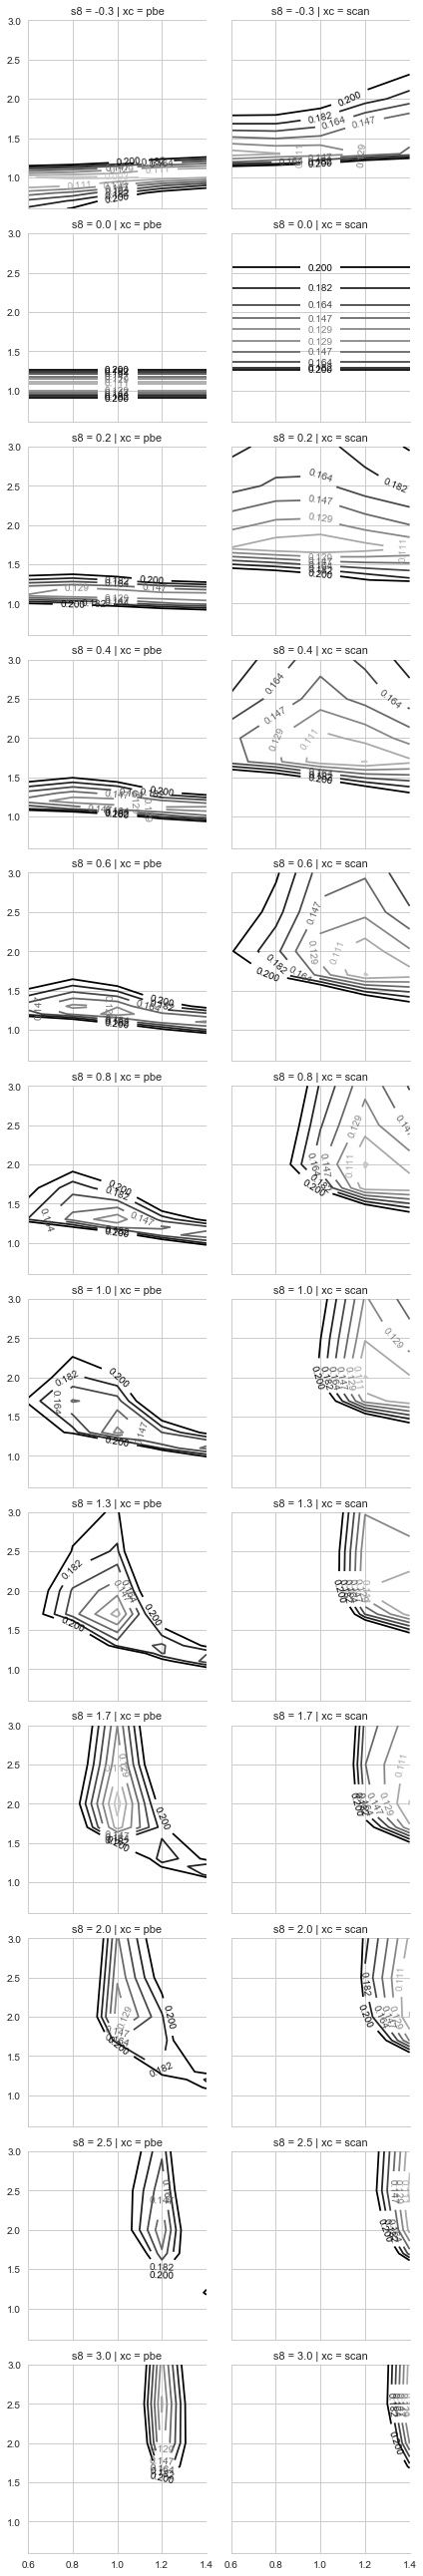

In [66]:
def plot_stat(**kwargs):
    df = kwargs.pop('data').groupby('sr6 sr8'.split()).apply(get_stat)
    df = df.MARE.reset_index().pivot(index='sr6', columns='sr8', values='MARE')
    mare = df.as_matrix()
    print(mare.min(), mare.max())
    p = sns.plt.contour(df.columns, df.index, mare, np.linspace(0.04, 0.2, 10))
    sns.plt.clabel(p, inline=1)

g = sns.FacetGrid(
    merge_scf_vdw(
        ('S66x8', slice(None), slice(None)),
        data_scf, (['pbe', 'scan'],),
        data_dftd3_0, (slice(None, 9.), slice(None), slice(None)),
        'sr6 sr8 s8'.split()
    ).reset_index(),
    col='xc',
    row='s8'
).map_dataframe(plot_stat)
# g.fig.legend(
#     (line1, line2), ('mean', 'standard deviation'),
#     loc='lower center', bbox_to_anchor=(.7, 0), ncol=2
# )
# g.fig.subplots_adjust(bottom=0.16, left=0.2, right=.93)
# sns.plt.ylim(-.4, .4)
# g.set_xlabels(r'$\beta$')
# g.set_ylabels(r'$\Delta E/E_\mathrm{ref}$')
# xticks = [.6, .8, 1, 1.2, 1.4]
# yticks = [-.3, 0, .3]
# g.set(xticks=xticks, yticks=yticks)
# g.set_xticklabels(xticks)
# g.set_yticklabels(['-30%', '0%', '30%'])
# savefig()
